<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 300 (delta 77), reused 141 (delta 31), pack-reused 80 (from 1)
Receiving objects: 100% (300/300), 216.45 MiB | 24.48 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (54/54), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [9]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [10]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [11]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## 1. Base Model - Avg Demand Only ##

In [12]:
demandDF = test_df[['avg_30_min_demand']]
demandDF

avg_30_min_demand
datetime_au                   
2016-01-01         6861.518333
2016-01-02         6731.957292
2016-01-03         6618.040000
2016-01-04         7358.550000
2016-01-05         7460.061875
...                        ...
2019-12-27         7508.199792
2019-12-28         7694.271458
2019-12-29         7746.240833
2019-12-30         8321.401042
2019-12-31         8503.726875

[1461 rows x 1 columns]

In [13]:
scaler = MinMaxScaler()
demandDF_scaled = pd.DataFrame(scaler.fit_transform(demandDF), index=demandDF.index, columns=demandDF.columns)

## Helper Functions ##

In [14]:
def to_X_and_y(df, window_size=7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def split_time_series(df, window_size=7, allow_overlap=False):
    years = sorted(df.index.year.unique())

    def get_year_slice(year):
        return df[df.index.year == year].copy()

    def get_extended_slice(current_year, prior_year):
        prior_tail = df[(df.index.year == prior_year) & (df.index >= f"{prior_year}-12-{31 - window_size + 1}")]
        current_full = get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    if allow_overlap:
        df_train = pd.concat([get_year_slice(years[0]), get_year_slice(years[1])])
        df_val = get_extended_slice(years[2], years[1])
        df_test = get_extended_slice(years[3], years[2])

    else:
        df_train = pd.concat([get_year_slice(years[0]), get_year_slice(years[1])])
        df_val = get_year_slice(years[2])
        df_test = get_year_slice(years[3])

    X_train, y_train = to_X_and_y(df_train, window_size)
    X_val, y_val = to_X_and_y(df_val, window_size)
    X_test, y_test = to_X_and_y(df_test, window_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)




In [266]:
class TimeSeriesPreprocessor:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessor):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [30]:
def predictions_plot(model, X, y, start = 0, end = 100):
    y_pred = model.predict(X)

    y_orig = scaler.inverse_transform(y.reshape(-1,1)).ravel()
    y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()

    predictions = model.predict(X).flatten()
    results = pd.DataFrame(data={'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [29]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_int("n_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train18.shape[1], X_train18.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train18, y_train18, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test18, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test[:, 0]

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

### Train, val, test splits

In [31]:
X, y = to_X_and_y(demandDF_scaled)
X.shape, y.shape

((1454, 7, 1), (1454,))

In [32]:
yearly_counts = demandDF_scaled.index.year.value_counts().sort_index()
print(yearly_counts)

datetime_au
2016    366
2017    365
2018    365
2019    365
Name: count, dtype: int64


In [33]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_time_series(demandDF_scaled, window_size=7, allow_overlap=False)

In [34]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((724, 7, 1), (724,), (358, 7, 1), (358,), (358, 7, 1), (358,))

In [35]:
(X_train2, y_train2), (X_val2, y_val2), (X_test2, y_test2) = split_time_series(demandDF_scaled, window_size=7, allow_overlap=True)

In [36]:
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((724, 7, 1), (724,), (365, 7, 1), (365,), (365, 7, 1), (365,))

### Model 1 ###

In [37]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
cp = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

In [39]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0845 - mean_absolute_percentage_error: 471681.8125 - root_mean_squared_error: 0.2832 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 39.0195 - val_root_mean_squared_error: 0.1166
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0167 - mean_absolute_percentage_error: 785055.1875 - root_mean_squared_error: 0.1291 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 37.1487 - val_root_mean_squared_error: 0.1140
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0179 - mean_absolute_percentage_error: 323137.0938 - root_mean_squared_error: 0.1337 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 36.8354 - val_root_mean_squared_error: 0.1134
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0181 - mean_absolute_percentage_error: 702045.3125 - root_mean_squared_error: 0.1345 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 35.7980 - val_root_mean_squared_error: 0.1122


In [40]:
model1 = load_model('model1.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


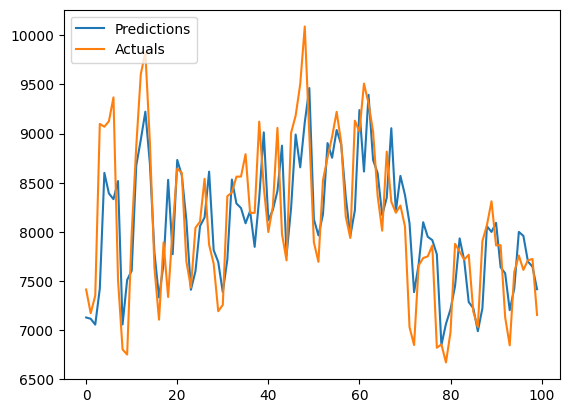

MAPE: 3.93%
RMSE: 429.73
MAE : 318.79


Predictions      Actuals
0    7127.474609  7412.811667
1    7114.430176  7171.183125
2    7055.062500  7350.264167
3    7421.334961  9098.258333
4    8600.084961  9070.002917
..           ...          ...
719  7837.726562  7374.332292
720  7861.724121  8039.583333
721  8189.655762  8575.767292
722  8362.522461  7909.507917
723  7559.448730  7144.386250

[724 rows x 2 columns]

In [41]:
predictions_plot(model1, X_train, y_train, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


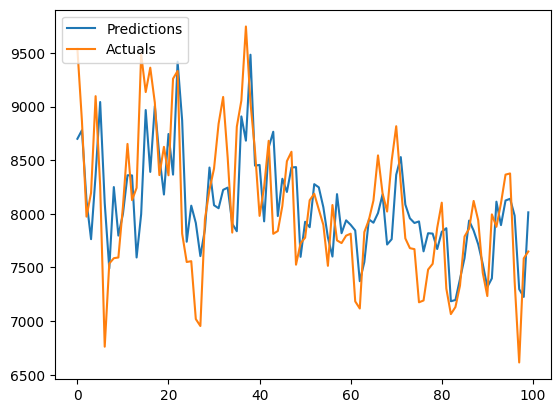

MAPE: 3.78%
RMSE: 391.01
MAE : 301.16


Predictions      Actuals
0    8699.094727  9537.097917
1    8778.881836  8863.333125
2    8121.864258  7973.787500
3    7763.624512  8194.981667
4    8363.201172  9096.434375
..           ...          ...
353  7894.114258  8447.030417
354  8108.739746  8771.408958
355  7907.863281  8487.014792
356  7570.236816  8380.489792
357  7700.037598  8437.980833

[358 rows x 2 columns]

In [42]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


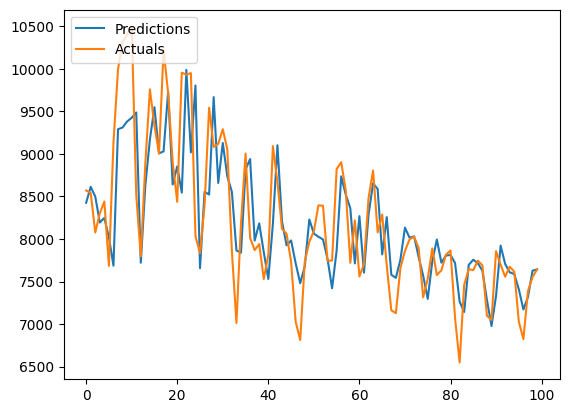

MAPE: 3.93%
RMSE: 419.02
MAE : 313.61


Predictions      Actuals
0    8425.806641  8569.568125
1    8612.348633  8540.904167
2    8499.933594  8076.513125
3    8193.828125  8302.971875
4    8247.337891  8440.820000
..           ...          ...
353  7585.859863  7508.199792
354  7714.319824  7694.271458
355  7501.583008  7746.240833
356  7539.206543  8321.401042
357  7813.067383  8503.726875

[358 rows x 2 columns]

In [43]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 ###

In [44]:
model2 = Sequential()
model2.add(InputLayer((7, 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
cp = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [46]:
model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0617 - root_mean_squared_error: 0.2444 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1206
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1294 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1111
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

In [47]:
model2 = load_model('model2.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


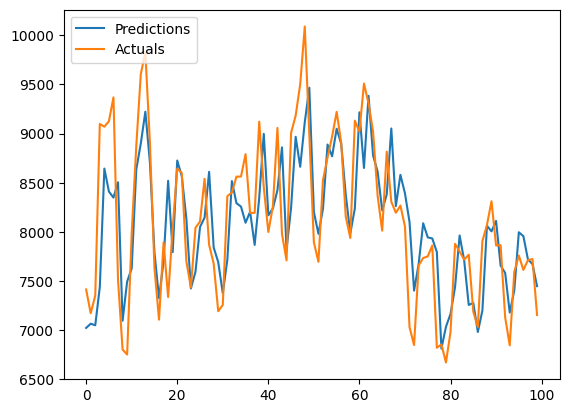

MAPE: 3.94%
RMSE: 429.50
MAE : 319.40


Predictions      Actuals
0    7020.990234  7412.811667
1    7064.029785  7171.183125
2    7048.233398  7350.264167
3    7436.756348  9098.258333
4    8643.748047  9070.002917
..           ...          ...
719  7841.463867  7374.332292
720  7852.019043  8039.583333
721  8190.331543  8575.767292
722  8394.991211  7909.507917
723  7605.250977  7144.386250

[724 rows x 2 columns]

In [48]:
predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


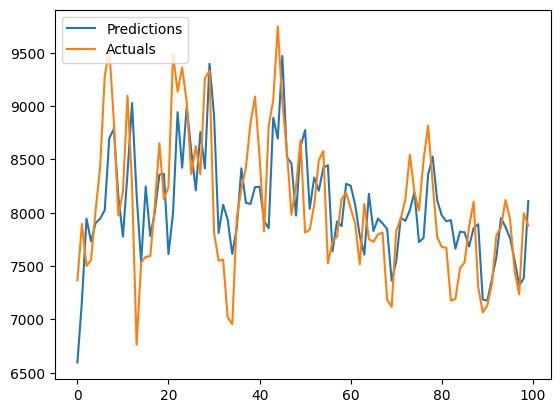

MAPE: 3.82%
RMSE: 396.79
MAE : 304.38


Predictions      Actuals
0    6596.331055  7365.989375
1    7173.582520  7895.121667
2    7944.617676  7501.373542
3    7729.966309  7557.751458
4    7903.398926  8021.308125
..           ...          ...
360  7917.997559  8447.030417
361  8099.923340  8771.408958
362  7936.151367  8487.014792
363  7630.369141  8380.489792
364  7701.583008  8437.980833

[365 rows x 2 columns]

In [49]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


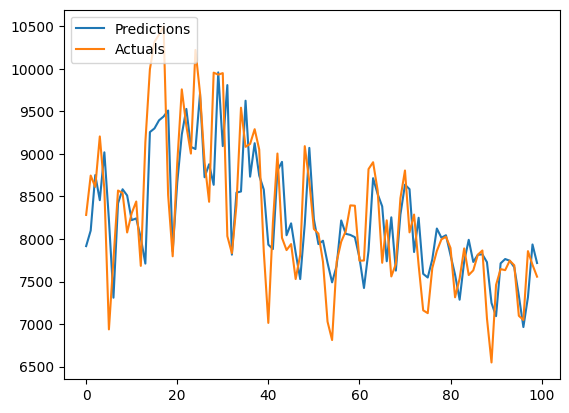

MAPE: 3.97%
RMSE: 423.34
MAE : 316.42


Predictions      Actuals
0    7916.460938  8282.850208
1    8099.284180  8745.688125
2    8751.277344  8612.550625
3    8456.431641  9205.374583
4    9018.716797  8584.935417
..           ...          ...
360  7579.268066  7508.199792
361  7737.082031  7694.271458
362  7471.911621  7746.240833
363  7587.494629  8321.401042
364  7876.844238  8503.726875

[365 rows x 2 columns]

In [50]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [51]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]
input_scaler = MinMaxScaler()
tempDemandDF_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF), index=tempDemandDF.index, columns=tempDemandDF.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF[['avg_30_min_demand']])

tempDemandDF_scaled.head()

avg_30_min_demand  avg_temp
datetime_au                             
2016-01-01            0.124113  0.552121
2016-01-02            0.095582  0.547043
2016-01-03            0.070495  0.568640
2016-01-04            0.233569  0.530455
2016-01-05            0.255923  0.482463

In [52]:
def multi_to_X_and_y(df, window_size=7, target_index=0):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size, :]
        X.append(row)
        label = df_as_np[i+window_size, target_index]
        y.append(label)
    return np.array(X), np.array(y)

In [53]:
X, y = multi_to_X_and_y(tempDemandDF_scaled)
X.shape, y.shape

((1454, 7, 2), (1454,))

In [54]:
(X_train3, y_train3), (X_val3, y_val3), (X_test3, y_test3) = split_time_series(tempDemandDF_scaled, window_size=7, allow_overlap=False)

In [55]:
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((724, 7, 2), (724,), (358, 7, 2), (358,), (358, 7, 2), (358,))

### Model 3 ###

In [56]:
model3 = Sequential()
model3.add(InputLayer((7, 2)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [58]:
model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0786 - root_mean_squared_error: 0.2753 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1458
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

In [59]:
model3 = load_model('model3.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


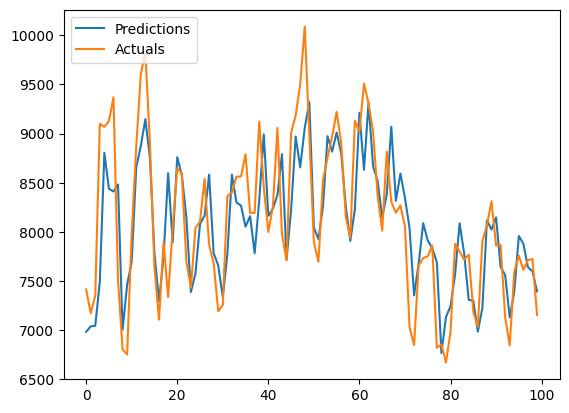

MAPE: 3.89%
RMSE: 424.28
MAE : 314.79


Predictions      Actuals
0    6981.710938  7412.811667
1    7036.945801  7171.183125
2    7042.759277  7350.264167
3    7490.090820  9098.258333
4    8804.273438  9070.002917
..           ...          ...
719  7917.599121  7374.332292
720  8005.068848  8039.583333
721  8355.625977  8575.767292
722  8526.664062  7909.507917
723  7727.046387  7144.386250

[724 rows x 2 columns]

In [60]:
predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


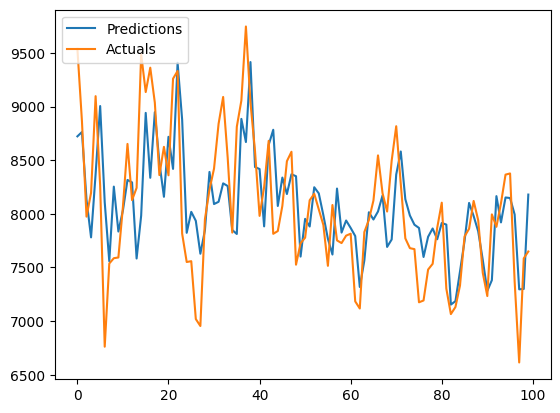

MAPE: 3.73%
RMSE: 384.70
MAE : 296.63


Predictions      Actuals
0    8721.823242  9537.097917
1    8762.183594  8863.333125
2    8132.183105  7973.787500
3    7780.475098  8194.981667
4    8370.845703  9096.434375
..           ...          ...
353  8012.559082  8447.030417
354  8308.589844  8771.408958
355  8215.657227  8487.014792
356  7867.751465  8380.489792
357  7854.194336  8437.980833

[358 rows x 2 columns]

In [61]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


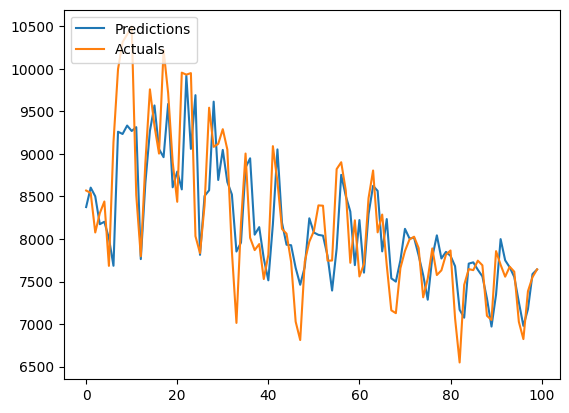

MAPE: 3.93%
RMSE: 420.25
MAE : 313.25


Predictions      Actuals
0    8375.486328  8569.568125
1    8603.882812  8540.904167
2    8501.477539  8076.513125
3    8173.850586  8302.971875
4    8202.782227  8440.820000
..           ...          ...
353  7715.762207  7508.199792
354  7950.135742  7694.271458
355  7813.062500  7746.240833
356  7873.629883  8321.401042
357  8117.751953  8503.726875

[358 rows x 2 columns]

In [62]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

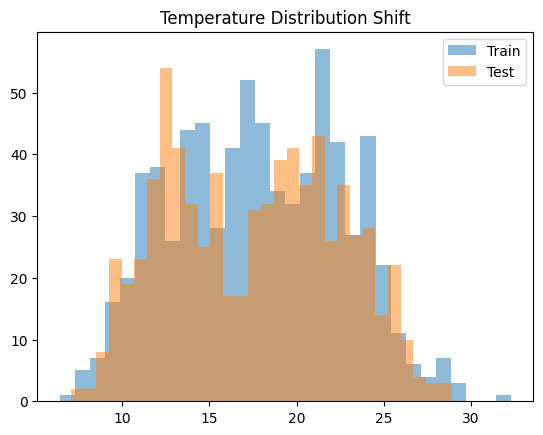

In [63]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [64]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]
input_scaler = MinMaxScaler()
tempDemandDF2_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF2), index=tempDemandDF2.index, columns=tempDemandDF2.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF2[['avg_30_min_demand']])

tempDemandDF2_scaled.head()

avg_30_min_demand  avg_temp  min_temp  max_temp
datetime_au                                                 
2016-01-01            0.124113  0.552121  0.615672  0.444099
2016-01-02            0.095582  0.547043  0.604478  0.388199
2016-01-03            0.070495  0.568640  0.757463  0.347826
2016-01-04            0.233569  0.530455  0.735075  0.354037
2016-01-05            0.255923  0.482463  0.697761  0.267081

In [65]:
X, y = multi_to_X_and_y(tempDemandDF2_scaled)
X.shape, y.shape

((1454, 7, 4), (1454,))

In [66]:
(X_train4, y_train4), (X_val4, y_val4), (X_test4, y_test4) = split_time_series(tempDemandDF2_scaled, window_size=7, allow_overlap=False)

In [67]:
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((724, 7, 4), (724,), (358, 7, 4), (358,), (358, 7, 4), (358,))

## Model 4 ##

In [68]:
model4 = Sequential()
model4.add(InputLayer((7, 4)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [70]:
model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0503 - root_mean_squared_error: 0.2220 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1281 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

In [71]:
model4 = load_model('model4.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


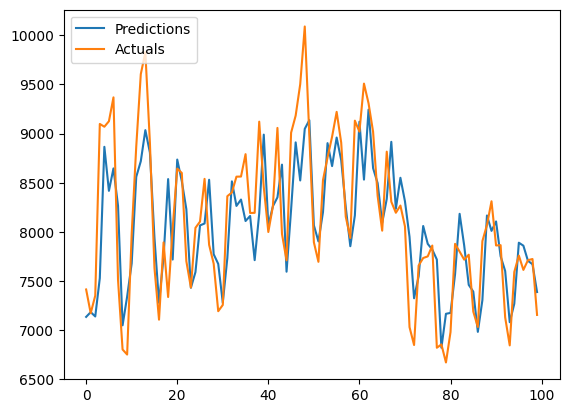

MAPE: 3.81%
RMSE: 418.87
MAE : 309.89


Predictions      Actuals
0    7133.596191  7412.811667
1    7182.092285  7171.183125
2    7137.892578  7350.264167
3    7528.375977  9098.258333
4    8865.458984  9070.002917
..           ...          ...
719  7738.937500  7374.332292
720  8032.480957  8039.583333
721  8367.916992  8575.767292
722  8515.881836  7909.507917
723  7698.712402  7144.386250

[724 rows x 2 columns]

In [72]:
predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


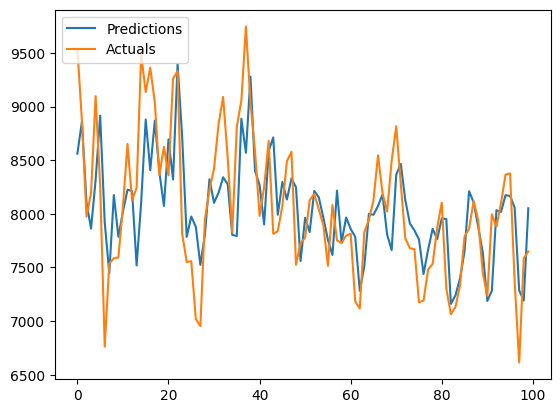

MAPE: 3.65%
RMSE: 377.66
MAE : 291.40


Predictions      Actuals
0    8560.820312  9537.097917
1    8861.388672  8863.333125
2    8104.802734  7973.787500
3    7862.172852  8194.981667
4    8314.883789  9096.434375
..           ...          ...
353  7973.619141  8447.030417
354  8469.841797  8771.408958
355  8431.372070  8487.014792
356  8021.335938  8380.489792
357  7900.143555  8437.980833

[358 rows x 2 columns]

In [73]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


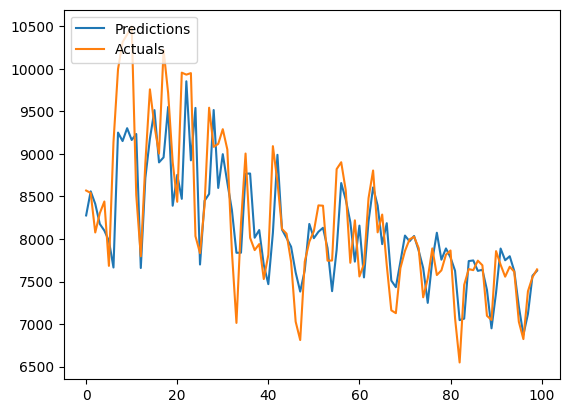

MAPE: 3.91%
RMSE: 416.08
MAE : 311.99


Predictions      Actuals
0    8277.008789  8569.568125
1    8560.166992  8540.904167
2    8412.520508  8076.513125
3    8176.863770  8302.971875
4    8098.690430  8440.820000
..           ...          ...
353  7744.057617  7508.199792
354  7973.557617  7694.271458
355  7951.750000  7746.240833
356  7949.675293  8321.401042
357  8141.179199  8503.726875

[358 rows x 2 columns]

In [74]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

In [75]:
zero_count = np.min(test_df["avg_30_min_demand"])
print(f"Number of zeros in y_true: {zero_count}")

Number of zeros in y_true: 6297.925208333333


## Model 5 ##

In [76]:
tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']].copy()
tempDemandDF3['temp_range'] = tempDemandDF3['max_temp'] - tempDemandDF3['min_temp']
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)
tempDemandDF3.head()

avg_30_min_demand   avg_temp  temp_range
datetime_au                                          
2016-01-01         6861.518333  20.704082        10.8
2016-01-02         6731.957292  20.572917         9.3
2016-01-03         6618.040000  21.130769         3.9
2016-01-04         7358.550000  20.144444         4.7
2016-01-05         7460.061875  18.904808         2.9

In [77]:
input_scaler = MinMaxScaler()
tempDemandDF3_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF3), index=tempDemandDF3.index, columns=tempDemandDF3.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF3[['avg_30_min_demand']])

tempDemandDF3_scaled.head()

avg_30_min_demand  avg_temp  temp_range
datetime_au                                         
2016-01-01            0.124113  0.552121    0.406114
2016-01-02            0.095582  0.547043    0.340611
2016-01-03            0.070495  0.568640    0.104803
2016-01-04            0.233569  0.530455    0.139738
2016-01-05            0.255923  0.482463    0.061135

In [78]:
X, y = multi_to_X_and_y(tempDemandDF3_scaled)
X.shape, y.shape

((1454, 7, 3), (1454,))

In [79]:
(X_train5, y_train5), (X_val5, y_val5), (X_test5, y_test5) = split_time_series(tempDemandDF3_scaled, window_size=7, allow_overlap=False)

In [80]:
X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((724, 7, 3), (724,), (358, 7, 3), (358,), (358, 7, 3), (358,))

In [81]:
model5 = Sequential()
model5.add(InputLayer((7, 3)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [83]:
model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0553 - root_mean_squared_error: 0.2315 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1339
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [84]:
model5 = load_model('model5.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


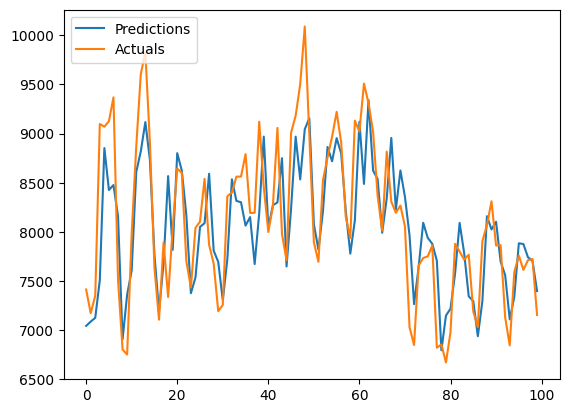

MAPE: 3.80%
RMSE: 416.99
MAE : 308.55


Predictions      Actuals
0    7042.104980  7412.811667
1    7085.415039  7171.183125
2    7124.565918  7350.264167
3    7507.292969  9098.258333
4    8852.501953  9070.002917
..           ...          ...
719  7906.458008  7374.332292
720  7997.423340  8039.583333
721  8337.350586  8575.767292
722  8506.207031  7909.507917
723  7675.572266  7144.386250

[724 rows x 2 columns]

In [85]:
predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


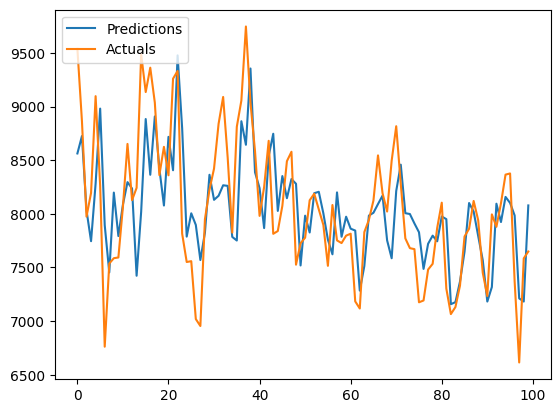

MAPE: 3.69%
RMSE: 381.35
MAE : 294.42


Predictions      Actuals
0    8562.523438  9537.097917
1    8724.634766  8863.333125
2    8032.097656  7973.787500
3    7744.992676  8194.981667
4    8281.666016  9096.434375
..           ...          ...
353  8010.123047  8447.030417
354  8363.368164  8771.408958
355  8210.461914  8487.014792
356  7744.496094  8380.489792
357  7642.672363  8437.980833

[358 rows x 2 columns]

In [86]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


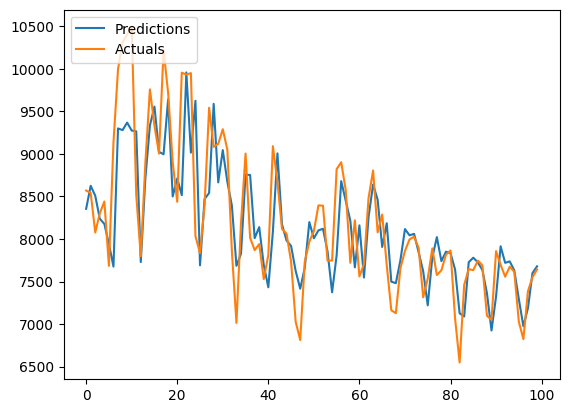

MAPE: 3.84%
RMSE: 408.76
MAE : 306.01


Predictions      Actuals
0    8354.750977  8569.568125
1    8625.329102  8540.904167
2    8508.098633  8076.513125
3    8238.113281  8302.971875
4    8177.333984  8440.820000
..           ...          ...
353  7689.188477  7508.199792
354  7901.181641  7694.271458
355  7781.507812  7746.240833
356  7858.255371  8321.401042
357  8075.394531  8503.726875

[358 rows x 2 columns]

In [87]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [88]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']].copy()
tempDemandDF4['temp_range'] = tempDemandDF4['max_temp'] - tempDemandDF4['min_temp']
tempDemandDF4.head()

avg_30_min_demand   avg_temp  min_temp  max_temp  temp_range
datetime_au                                                              
2016-01-01         6861.518333  20.704082      15.2      26.0        10.8
2016-01-02         6731.957292  20.572917      14.9      24.2         9.3
2016-01-03         6618.040000  21.130769      19.0      22.9         3.9
2016-01-04         7358.550000  20.144444      18.4      23.1         4.7
2016-01-05         7460.061875  18.904808      17.4      20.3         2.9

In [89]:
input_scaler = MinMaxScaler()
tempDemandDF4_scaled = pd.DataFrame(input_scaler.fit_transform(tempDemandDF4), index=tempDemandDF4.index, columns=tempDemandDF4.columns)

target_scaler = MinMaxScaler()
target_scaler.fit(tempDemandDF4[['avg_30_min_demand']])

tempDemandDF4_scaled.head()

avg_30_min_demand  avg_temp  min_temp  max_temp  temp_range
datetime_au                                                             
2016-01-01            0.124113  0.552121  0.615672  0.444099    0.406114
2016-01-02            0.095582  0.547043  0.604478  0.388199    0.340611
2016-01-03            0.070495  0.568640  0.757463  0.347826    0.104803
2016-01-04            0.233569  0.530455  0.735075  0.354037    0.139738
2016-01-05            0.255923  0.482463  0.697761  0.267081    0.061135

In [90]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled)
X.shape, y.shape

((1454, 7, 5), (1454,))

In [91]:
(X_train6, y_train6), (X_val6, y_val6), (X_test6, y_test6) = split_time_series(tempDemandDF4_scaled, window_size=7, allow_overlap=False)

In [92]:
X_train6.shape, y_train6.shape, X_val6.shape, y_val6.shape, X_test6.shape, y_test6.shape

((724, 7, 5), (724,), (358, 7, 5), (358,), (358, 7, 5), (358,))

In [93]:
model6 = Sequential()
model6.add(InputLayer((7, 5)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [95]:
model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0636 - root_mean_squared_error: 0.2505 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0252 - root_mean_squared_error: 0.1584 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - root_mean_squared_error: 0.1369 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step -

In [96]:
model6 = load_model('model6.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


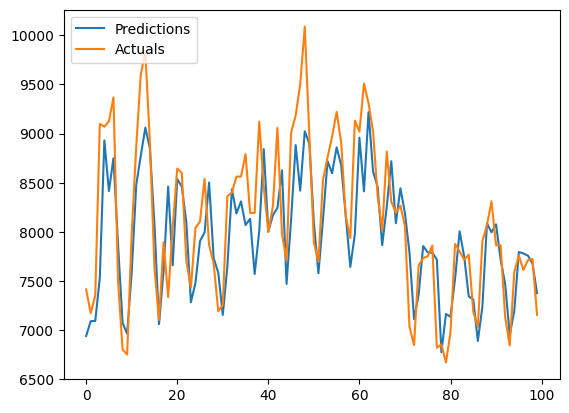

MAPE: 3.72%
RMSE: 412.39
MAE : 303.13


Predictions      Actuals
0    6938.847656  7412.811667
1    7090.458008  7171.183125
2    7091.905762  7350.264167
3    7529.337402  9098.258333
4    8930.776367  9070.002917
..           ...          ...
719  7616.729004  7374.332292
720  7934.981934  8039.583333
721  8271.617188  8575.767292
722  8446.864258  7909.507917
723  7609.883301  7144.386250

[724 rows x 2 columns]

In [97]:
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


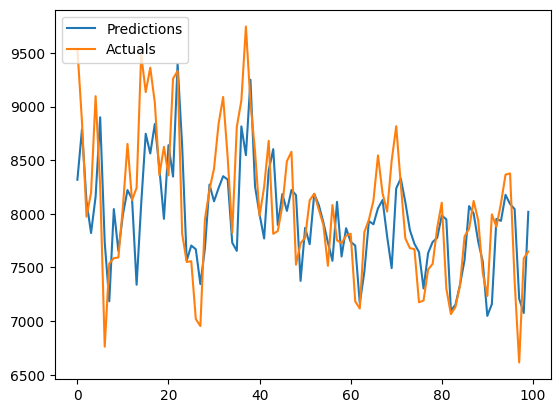

MAPE: 3.58%
RMSE: 376.70
MAE : 286.34


Predictions      Actuals
0    8317.559570  9537.097917
1    8784.466797  8863.333125
2    8115.435059  7973.787500
3    7821.086914  8194.981667
4    8159.912598  9096.434375
..           ...          ...
353  7965.372070  8447.030417
354  8434.023438  8771.408958
355  8411.687500  8487.014792
356  7941.499023  8380.489792
357  7696.005859  8437.980833

[358 rows x 2 columns]

In [98]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


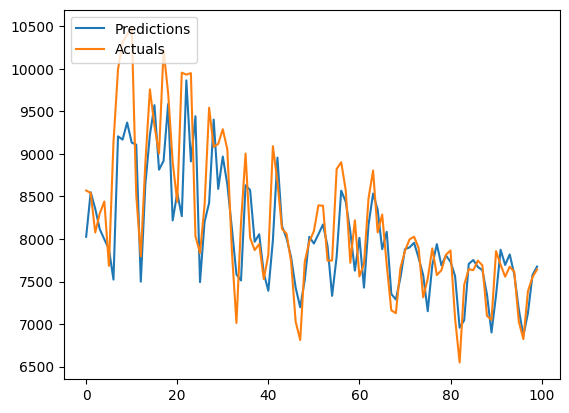

MAPE: 3.79%
RMSE: 413.15
MAE : 303.16


Predictions      Actuals
0    8026.067383  8569.568125
1    8549.975586  8540.904167
2    8354.502930  8076.513125
3    8114.279785  8302.971875
4    7995.427246  8440.820000
..           ...          ...
353  7662.714355  7508.199792
354  7820.299316  7694.271458
355  7892.187988  7746.240833
356  7874.200195  8321.401042
357  8081.068359  8503.726875

[358 rows x 2 columns]

In [99]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [100]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled, window_size=10)
X.shape, y.shape

((1451, 10, 5), (1451,))

In [101]:
(X_train7, y_train7), (X_val7, y_val7), (X_test7, y_test7) = split_time_series(tempDemandDF4_scaled, window_size=10, allow_overlap=False)

In [102]:
X_train7.shape, y_train7.shape, X_val7.shape, y_val7.shape, X_test7.shape, y_test7.shape

((721, 10, 5), (721,), (355, 10, 5), (355,), (355, 10, 5), (355,))

In [103]:
model7 = Sequential()
model7.add(InputLayer((10, 5)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [105]:
model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1596 - root_mean_squared_error: 0.3878 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

In [106]:
model7 = load_model('model7.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


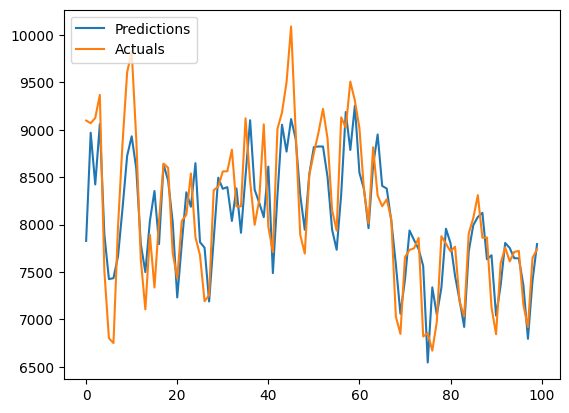

MAPE: 3.65%
RMSE: 400.62
MAE : 295.08


Predictions      Actuals
0    7828.178711  9098.258333
1    8969.564453  9070.002917
2    8423.730469  9125.678750
3    9060.301758  9368.951875
4    7897.087402  7510.325833
..           ...          ...
716  7447.771484  7374.332292
717  7719.457520  8039.583333
718  8011.746094  8575.767292
719  8256.124023  7909.507917
720  7071.228027  7144.386250

[721 rows x 2 columns]

In [107]:
predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


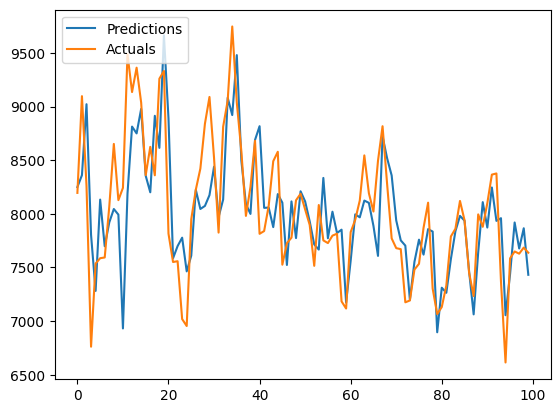

MAPE: 3.59%
RMSE: 375.93
MAE : 285.48


Predictions      Actuals
0    8249.525391  8194.981667
1    8360.143555  9096.434375
2    9021.363281  8261.405417
3    7803.458984  6761.608125
4    7281.423828  7536.762292
..           ...          ...
350  7741.478516  8447.030417
351  8235.590820  8771.408958
352  8273.499023  8487.014792
353  7661.691895  8380.489792
354  7717.115723  8437.980833

[355 rows x 2 columns]

In [108]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


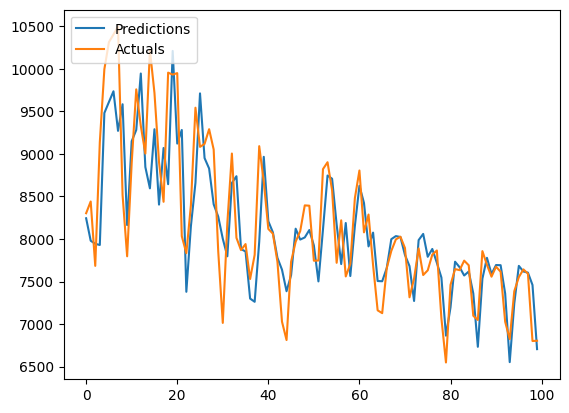

MAPE: 3.87%
RMSE: 410.13
MAE : 307.81


Predictions      Actuals
0    8243.608398  8302.971875
1    7979.511719  8440.820000
2    7943.743652  7684.176042
3    7929.643555  9135.772083
4    9480.817383  9995.508542
..           ...          ...
350  7531.610352  7508.199792
351  7607.331055  7694.271458
352  7756.041504  7746.240833
353  7668.895996  8321.401042
354  8152.430176  8503.726875

[355 rows x 2 columns]

In [109]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

## Model 8 - Decrease Window Size to 5 ##

In [110]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled, window_size=5)
X.shape, y.shape

((1456, 5, 5), (1456,))

In [111]:
(X_train8, y_train8), (X_val8, y_val8), (X_test8, y_test8) = split_time_series(tempDemandDF4_scaled, window_size=5, allow_overlap=False)

In [112]:
X_train8.shape, y_train8.shape, X_val8.shape, y_val8.shape, X_test8.shape, y_test8.shape

((726, 5, 5), (726,), (360, 5, 5), (360,), (360, 5, 5), (360,))

In [113]:
model8 = Sequential()
model8.add(InputLayer((5, 5)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [115]:
model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1002 - root_mean_squared_error: 0.3113 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1732
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1226
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - root_mean_squared_error: 0.1457 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0214 - root_mean_squared_error: 0.1459 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

In [116]:
model8 = load_model('model8.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


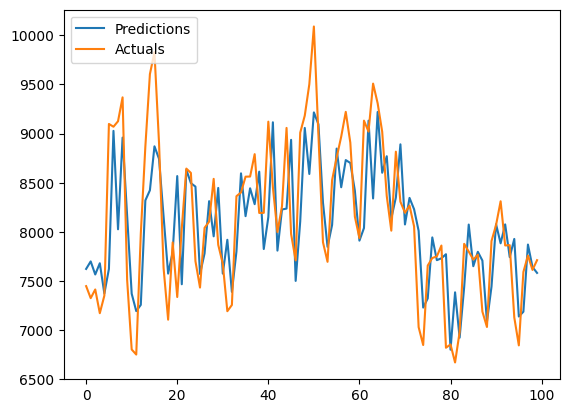

MAPE: 4.22%
RMSE: 450.64
MAE : 339.46


Predictions      Actuals
0    7622.073730  7446.897083
1    7698.566895  7324.388958
2    7565.605469  7412.811667
3    7679.995117  7171.183125
4    7371.738281  7350.264167
..           ...          ...
721  7298.828613  7374.332292
722  7806.067383  8039.583333
723  8135.117676  8575.767292
724  8374.961914  7909.507917
725  7365.815430  7144.386250

[726 rows x 2 columns]

In [117]:
predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


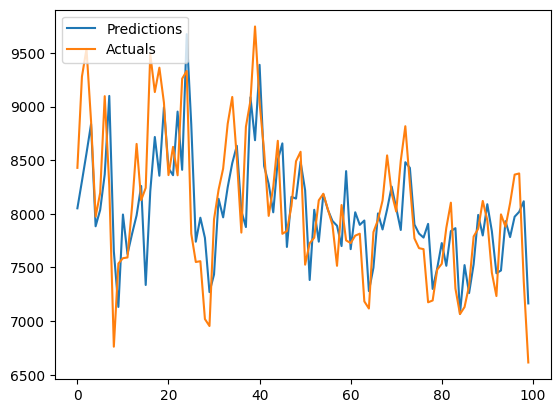

MAPE: 3.96%
RMSE: 404.36
MAE : 314.85


Predictions      Actuals
0    8051.303711  8428.290208
1    8304.830078  9279.195417
2    8564.722656  9537.097917
3    8836.294922  8863.333125
4    7883.898438  7973.787500
..           ...          ...
355  7710.038086  8447.030417
356  8176.303711  8771.408958
357  8226.002930  8487.014792
358  7927.158691  8380.489792
359  8000.918945  8437.980833

[360 rows x 2 columns]

In [118]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


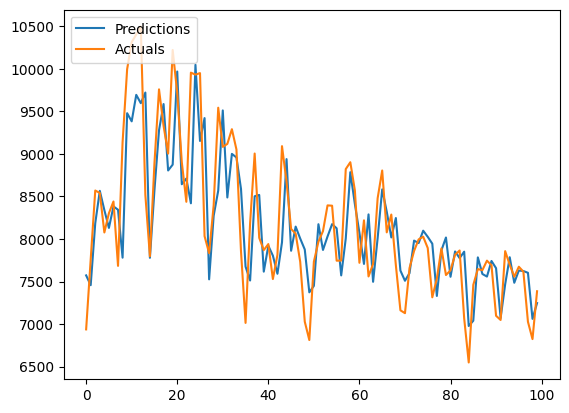

MAPE: 4.14%
RMSE: 425.48
MAE : 326.64


Predictions      Actuals
0    7572.385742  6937.700208
1    7456.987793  7759.521667
2    8185.263672  8569.568125
3    8566.167969  8540.904167
4    8339.710938  8076.513125
..           ...          ...
355  7669.525391  7508.199792
356  7704.395508  7694.271458
357  7831.256836  7746.240833
358  7742.630859  8321.401042
359  8249.558594  8503.726875

[360 rows x 2 columns]

In [119]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [137]:
X, y = multi_to_X_and_y(tempDemandDF4_scaled, window_size=14)
X.shape, y.shape

((1447, 14, 5), (1447,))

In [138]:
(X_train9, y_train9), (X_val9, y_val9), (X_test9, y_test9) = split_time_series(tempDemandDF4_scaled, window_size=14, allow_overlap=False)

In [139]:
X_train9.shape, y_train9.shape, X_val9.shape, y_val9.shape, X_test9.shape, y_test9.shape

((717, 14, 5), (717,), (351, 14, 5), (351,), (351, 14, 5), (351,))

In [140]:
model9 = Sequential()
model9.add(InputLayer((14, 5)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [142]:
model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0501 - root_mean_squared_error: 0.2225 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0221 - root_mean_squared_error: 0.1484 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0178 - root_mean_squared_error: 0.1332 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - root_mean_squared_error: 0.1235 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - root_mean_squared_error: 0.1233 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

In [126]:
model9 = load_model('model9.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


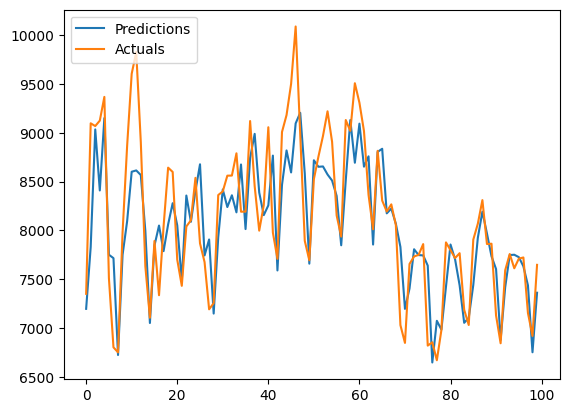

MAPE: 3.40%
RMSE: 379.53
MAE : 275.99


Predictions      Actuals
0    7196.461914  7350.264167
1    7830.954102  9098.258333
2    9035.509766  9070.002917
3    8409.927734  9125.678750
4    9151.637695  9368.951875
..           ...          ...
717  7104.462891  7374.332292
718  7475.428223  8039.583333
719  7878.093750  8575.767292
720  8208.768555  7909.507917
721  7381.732910  7144.386250

[722 rows x 2 columns]

In [127]:
predictions_plot(model9, X_train9, y_train9, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


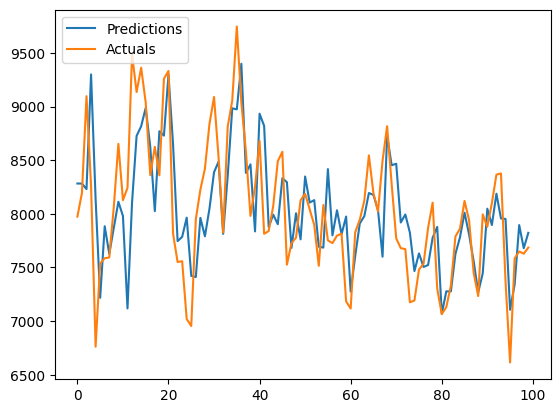

MAPE: 3.44%
RMSE: 369.39
MAE : 274.20


Predictions      Actuals
0    8282.426758  7973.787500
1    8281.827148  8194.981667
2    8230.365234  9096.434375
3    9298.748047  8261.405417
4    8135.509277  6761.608125
..           ...          ...
351  7493.815430  8447.030417
352  7999.788574  8771.408958
353  8122.618164  8487.014792
354  7687.991211  8380.489792
355  7661.470703  8437.980833

[356 rows x 2 columns]

In [128]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


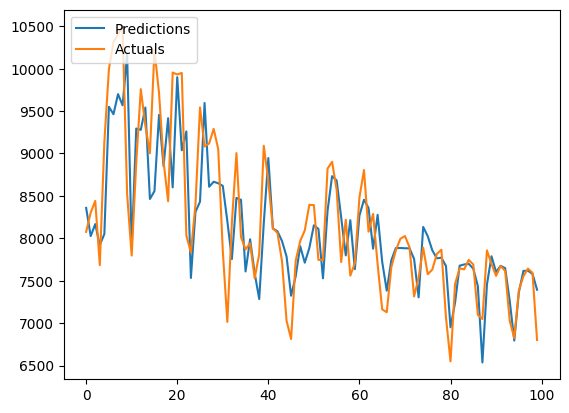

MAPE: 3.64%
RMSE: 400.81
MAE : 290.54


Predictions      Actuals
0    8358.742188  8076.513125
1    8026.007812  8302.971875
2    8167.654785  8440.820000
3    7919.238281  7684.176042
4    8052.052246  9135.772083
..           ...          ...
351  7405.919922  7508.199792
352  7514.560059  7694.271458
353  7697.703125  7746.240833
354  7650.799805  8321.401042
355  8412.013672  8503.726875

[356 rows x 2 columns]

In [129]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [130]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
tempDemandDF5['temp_range'] = tempDemandDF5['max_temp'] - tempDemandDF5['min_temp']
tempDemandDF5.head()

avg_30_min_demand   avg_temp  min_temp  max_temp  hd_next_24h  \
datetime_au                                                                  
2016-01-01         6861.518333  20.704082      15.2      26.0          0.0   
2016-01-02         6731.957292  20.572917      14.9      24.2          0.0   
2016-01-03         6618.040000  21.130769      19.0      22.9          0.0   
2016-01-04         7358.550000  20.144444      18.4      23.1          0.0   
2016-01-05         7460.061875  18.904808      17.4      20.3          0.0   

             cd_next_24h  temp_range  
datetime_au                           
2016-01-01      1.204082        10.8  
2016-01-02      1.072917         9.3  
2016-01-03      1.630769         3.9  
2016-01-04      0.644444         4.7  
2016-01-05      0.000000         2.9

In [131]:
preprocessor = TimeSeriesPreprocessor(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_index=0)

X_train10, y_train10 = data['train']
X_val10, y_val10 = data['val']
X_test10, y_test10 = data['test']

In [132]:
X_train10.shape, y_train10.shape, X_val10.shape, y_val10.shape, X_test10.shape, y_test10.shape

((724, 7, 7), (724,), (358, 7, 7), (358,), (358, 7, 7), (358,))

In [147]:
model10 = Sequential()
model10.add(InputLayer((7, 7)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [149]:
model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0383 - root_mean_squared_error: 0.1936 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - root_mean_squared_error: 0.1222 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0158 - root_mean_squared_error: 0.1254 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - root_mean_squared_error: 0.1226 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [150]:
model10 = load_model('model10.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


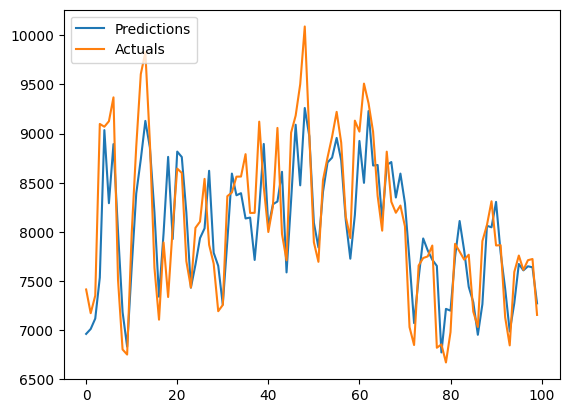

MAPE: 3.31%
RMSE: 369.47
MAE : 267.38


Predictions      Actuals
0    6960.363770  7412.811667
1    7010.572266  7171.183125
2    7116.454590  7350.264167
3    7534.375000  9098.258333
4    9035.560547  9070.002917
..           ...          ...
719  7913.599121  7374.332292
720  8130.183594  8039.583333
721  8247.380859  8575.767292
722  8235.333984  7909.507917
723  7443.222168  7144.386250

[724 rows x 2 columns]

In [151]:
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


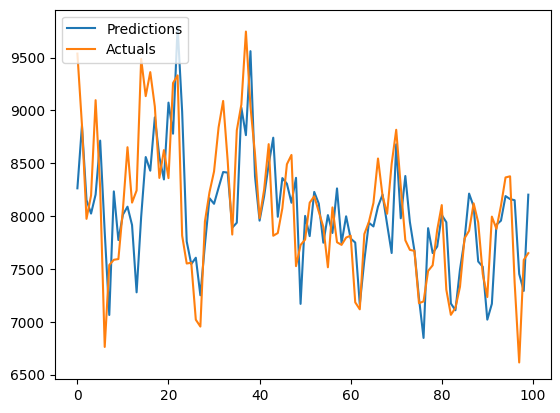

MAPE: 3.46%
RMSE: 370.19
MAE : 275.91


Predictions      Actuals
0    8262.459961  9537.097917
1    8855.337891  8863.333125
2    8151.378906  7973.787500
3    8023.488281  8194.981667
4    8203.653320  9096.434375
..           ...          ...
353  7932.103516  8447.030417
354  8389.039062  8771.408958
355  8416.257812  8487.014792
356  7923.401367  8380.489792
357  7723.934570  8437.980833

[358 rows x 2 columns]

In [152]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


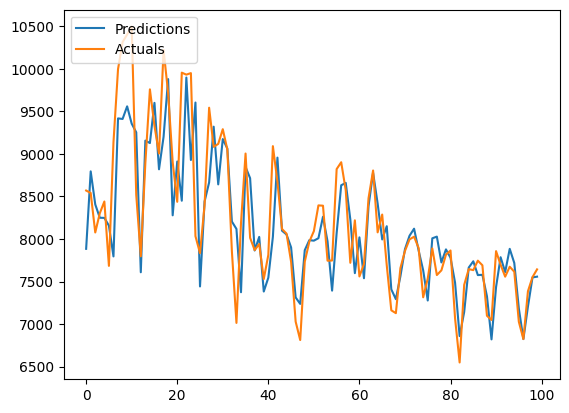

MAPE: 3.79%
RMSE: 403.62
MAE : 300.82


Predictions      Actuals
0    7884.556641  8569.568125
1    8794.885742  8540.904167
2    8406.503906  8076.513125
3    8249.666992  8302.971875
4    8248.134766  8440.820000
..           ...          ...
353  7888.887207  7508.199792
354  7921.492676  7694.271458
355  7967.223145  7746.240833
356  7904.032227  8321.401042
357  7789.104980  8503.726875

[358 rows x 2 columns]

In [153]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [154]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
tempDemandDF6['temp_range'] = tempDemandDF6['max_temp'] - tempDemandDF6['min_temp']
tempDemandDF6.head()

avg_30_min_demand  min_temp  max_temp  hd_next_24h  cd_next_24h  \
datetime_au                                                                    
2016-01-01         6861.518333      15.2      26.0          0.0     1.204082   
2016-01-02         6731.957292      14.9      24.2          0.0     1.072917   
2016-01-03         6618.040000      19.0      22.9          0.0     1.630769   
2016-01-04         7358.550000      18.4      23.1          0.0     0.644444   
2016-01-05         7460.061875      17.4      20.3          0.0     0.000000   

             temp_range  
datetime_au              
2016-01-01         10.8  
2016-01-02          9.3  
2016-01-03          3.9  
2016-01-04          4.7  
2016-01-05          2.9

In [155]:
preprocessor11 = TimeSeriesPreprocessor(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor11.split()
preprocessor11.scale()
data11 = preprocessor11.get_model_inputs(target_index=0)

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

In [156]:
X_train11.shape, y_train11.shape, X_val11.shape, y_val11.shape, X_test11.shape, y_test11.shape

((724, 7, 6), (724,), (358, 7, 6), (358,), (358, 7, 6), (358,))

In [157]:
model11 = Sequential()
model11.add(InputLayer((7, 6)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [159]:
model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1047 - root_mean_squared_error: 0.3155 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1282
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1231
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186 - root_mean_squared_error: 0.1362 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [161]:
model11 = load_model('model11.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


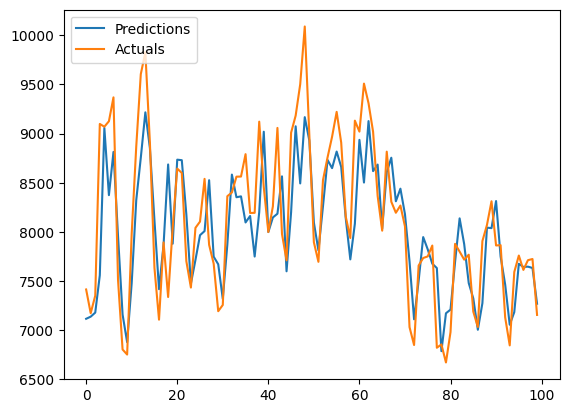

MAPE: 3.49%
RMSE: 388.04
MAE : 282.94


Predictions      Actuals
0    7114.356934  7412.811667
1    7135.961914  7171.183125
2    7177.488281  7350.264167
3    7557.497559  9098.258333
4    9057.471680  9070.002917
..           ...          ...
719  7795.650879  7374.332292
720  8154.080078  8039.583333
721  8307.448242  8575.767292
722  8310.392578  7909.507917
723  7553.455078  7144.386250

[724 rows x 2 columns]

In [162]:
predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


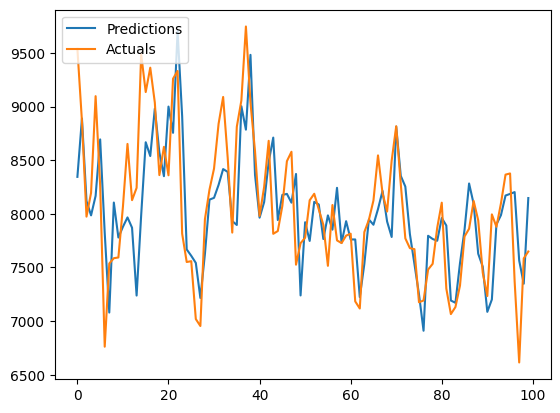

MAPE: 3.52%
RMSE: 370.06
MAE : 281.59


Predictions      Actuals
0    8344.351562  9537.097917
1    8887.999023  8863.333125
2    8119.284668  7973.787500
3    7985.539062  8194.981667
4    8167.085938  9096.434375
..           ...          ...
353  7981.812500  8447.030417
354  8422.191406  8771.408958
355  8460.997070  8487.014792
356  7953.809082  8380.489792
357  7748.330078  8437.980833

[358 rows x 2 columns]

In [163]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


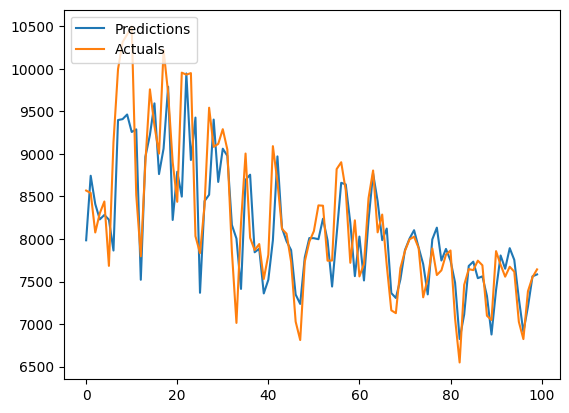

MAPE: 3.93%
RMSE: 411.24
MAE : 311.87


Predictions      Actuals
0    7984.881348  8569.568125
1    8743.311523  8540.904167
2    8410.748047  8076.513125
3    8230.437500  8302.971875
4    8282.775391  8440.820000
..           ...          ...
353  7944.641602  7508.199792
354  8059.383789  7694.271458
355  8123.912598  7746.240833
356  8017.242676  8321.401042
357  7860.689941  8503.726875

[358 rows x 2 columns]

In [165]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [166]:
tempDemandDF7 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation']].copy()
tempDemandDF7['temp_range'] = tempDemandDF7['max_temp'] - tempDemandDF7['min_temp']
tempDemandDF7.head()

avg_30_min_demand   avg_temp  min_temp  max_temp  hd_next_24h  \
datetime_au                                                                  
2016-01-01         6861.518333  20.704082      15.2      26.0          0.0   
2016-01-02         6731.957292  20.572917      14.9      24.2          0.0   
2016-01-03         6618.040000  21.130769      19.0      22.9          0.0   
2016-01-04         7358.550000  20.144444      18.4      23.1          0.0   
2016-01-05         7460.061875  18.904808      17.4      20.3          0.0   

             cd_next_24h  precipitation  temp_range  
datetime_au                                          
2016-01-01      1.204082       2.140095        10.8  
2016-01-02      1.072917       6.496326         9.3  
2016-01-03      1.630769       8.562486         3.9  
2016-01-04      0.644444       4.082204         4.7  
2016-01-05      0.000000       9.977372         2.9

In [167]:
preprocessor12 = TimeSeriesPreprocessor(tempDemandDF7, window_size=7, allow_overlap=False)
preprocessor12.split()
preprocessor12.scale()
data12 = preprocessor12.get_model_inputs(target_index=0)

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

In [168]:
X_train12.shape, y_train12.shape, X_val12.shape, y_val12.shape, X_test12.shape, y_test12.shape

((724, 7, 8), (724,), (358, 7, 8), (358,), (358, 7, 8), (358,))

In [169]:
model12 = Sequential()
model12.add(InputLayer((7, 8)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [171]:
model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0721 - root_mean_squared_error: 0.2629 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - root_mean_squared_error: 0.1309 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1098
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

In [172]:
model12 = load_model('model12.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


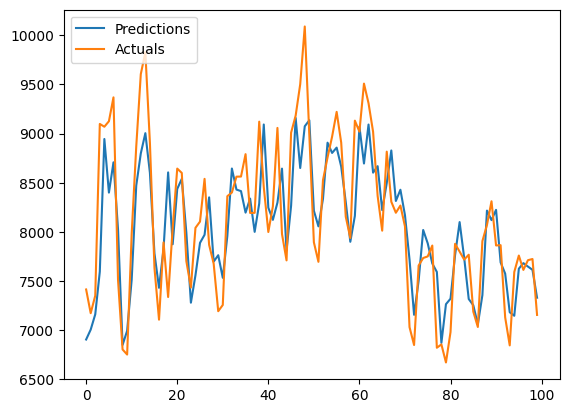

MAPE: 3.54%
RMSE: 387.19
MAE : 286.75


Predictions      Actuals
0    6903.232910  7412.811667
1    7003.949219  7171.183125
2    7159.519531  7350.264167
3    7594.630371  9098.258333
4    8945.039062  9070.002917
..           ...          ...
719  7883.830078  7374.332292
720  8240.609375  8039.583333
721  8265.255859  8575.767292
722  8043.342773  7909.507917
723  7464.515137  7144.386250

[724 rows x 2 columns]

In [173]:
predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


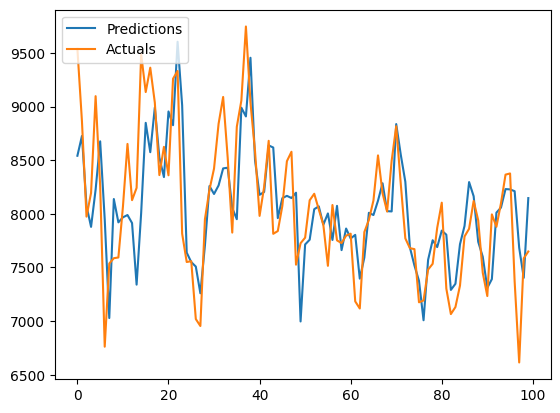

MAPE: 3.52%
RMSE: 365.82
MAE : 279.76


Predictions      Actuals
0    8541.000977  9537.097917
1    8725.433594  8863.333125
2    8074.701660  7973.787500
3    7878.481445  8194.981667
4    8225.072266  9096.434375
..           ...          ...
353  8018.828613  8447.030417
354  8377.775391  8771.408958
355  8498.087891  8487.014792
356  8088.954590  8380.489792
357  7955.743652  8437.980833

[358 rows x 2 columns]

In [174]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


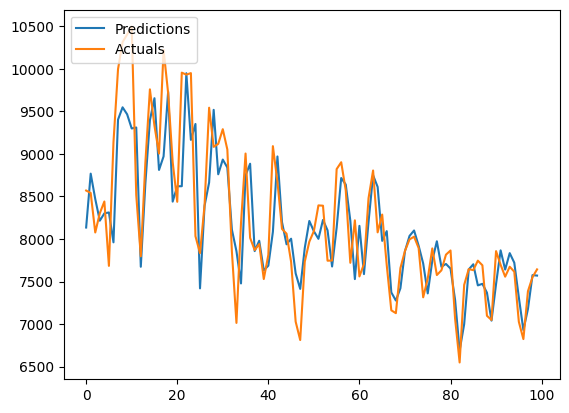

MAPE: 4.01%
RMSE: 414.56
MAE : 317.31


Predictions      Actuals
0    8134.853027  8569.568125
1    8768.032227  8540.904167
2    8470.297852  8076.513125
3    8215.216797  8302.971875
4    8301.260742  8440.820000
..           ...          ...
353  8034.710938  7508.199792
354  8154.365723  7694.271458
355  8134.284668  7746.240833
356  7978.652344  8321.401042
357  7939.851562  8503.726875

[358 rows x 2 columns]

In [175]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [176]:
tempDemandDF8 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight']].copy()
tempDemandDF8['temp_range'] = tempDemandDF8['max_temp'] - tempDemandDF8['min_temp']
tempDemandDF8.head()

avg_30_min_demand   avg_temp  min_temp  max_temp  hd_next_24h  \
datetime_au                                                                  
2016-01-01         6861.518333  20.704082      15.2      26.0          0.0   
2016-01-02         6731.957292  20.572917      14.9      24.2          0.0   
2016-01-03         6618.040000  21.130769      19.0      22.9          0.0   
2016-01-04         7358.550000  20.144444      18.4      23.1          0.0   
2016-01-05         7460.061875  18.904808      17.4      20.3          0.0   

             cd_next_24h  sunlight  temp_range  
datetime_au                                     
2016-01-01      1.204082      32.3        10.8  
2016-01-02      1.072917      23.2         9.3  
2016-01-03      1.630769      12.7         3.9  
2016-01-04      0.644444       7.6         4.7  
2016-01-05      0.000000       3.9         2.9

In [177]:
preprocessor13 = TimeSeriesPreprocessor(tempDemandDF8, window_size=7, allow_overlap=False)
preprocessor13.split()
preprocessor13.scale()
data13 = preprocessor13.get_model_inputs(target_index=0)

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

In [178]:
X_train13.shape, y_train13.shape, X_val13.shape, y_val13.shape, X_test13.shape, y_test13.shape

((724, 7, 8), (724,), (358, 7, 8), (358,), (358, 7, 8), (358,))

In [179]:
model13 = Sequential()
model13.add(InputLayer((7, 8)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [181]:
model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0539 - root_mean_squared_error: 0.2302 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1300 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - 

In [182]:
model13 = load_model('model13.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


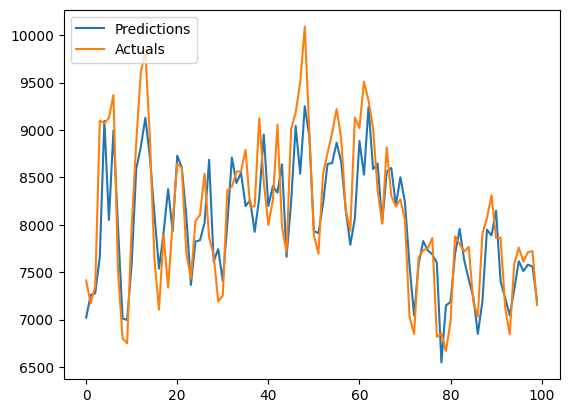

MAPE: 3.31%
RMSE: 367.20
MAE : 267.47


Predictions      Actuals
0    7021.686523  7412.811667
1    7259.431641  7171.183125
2    7278.829102  7350.264167
3    7662.893066  9098.258333
4    9095.483398  9070.002917
..           ...          ...
719  7715.790039  7374.332292
720  8161.941895  8039.583333
721  8368.260742  8575.767292
722  8245.891602  7909.507917
723  7637.409668  7144.386250

[724 rows x 2 columns]

In [183]:
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


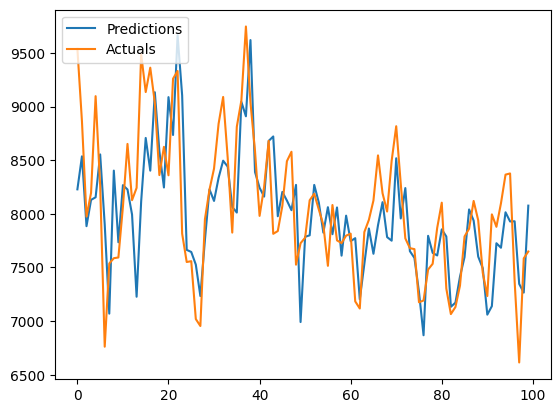

MAPE: 3.46%
RMSE: 367.30
MAE : 275.64


Predictions      Actuals
0    8228.084961  9537.097917
1    8535.690430  8863.333125
2    7884.807617  7973.787500
3    8129.895996  8194.981667
4    8153.980957  9096.434375
..           ...          ...
353  8207.243164  8447.030417
354  8605.909180  8771.408958
355  8542.696289  8487.014792
356  8146.005371  8380.489792
357  7976.684082  8437.980833

[358 rows x 2 columns]

In [184]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


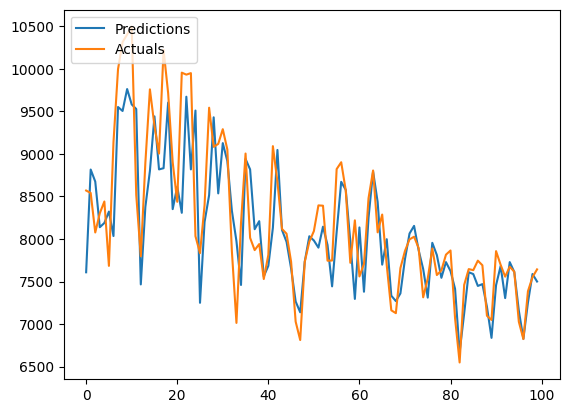

MAPE: 3.84%
RMSE: 413.03
MAE : 304.94


Predictions      Actuals
0    7608.856445  8569.568125
1    8816.436523  8540.904167
2    8674.855469  8076.513125
3    8138.512695  8302.971875
4    8188.466309  8440.820000
..           ...          ...
353  8098.385254  7508.199792
354  8163.992188  7694.271458
355  8267.606445  7746.240833
356  8137.203613  8321.401042
357  8028.544922  8503.726875

[358 rows x 2 columns]

In [185]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

## Model 14 - Precipitation and Sunlight ##

In [186]:
tempDemandDF9 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight']].copy()
tempDemandDF9['temp_range'] = tempDemandDF9['max_temp'] - tempDemandDF9['min_temp']
tempDemandDF9.head()

avg_30_min_demand   avg_temp  min_temp  max_temp  hd_next_24h  \
datetime_au                                                                  
2016-01-01         6861.518333  20.704082      15.2      26.0          0.0   
2016-01-02         6731.957292  20.572917      14.9      24.2          0.0   
2016-01-03         6618.040000  21.130769      19.0      22.9          0.0   
2016-01-04         7358.550000  20.144444      18.4      23.1          0.0   
2016-01-05         7460.061875  18.904808      17.4      20.3          0.0   

             cd_next_24h  precipitation  sunlight  temp_range  
datetime_au                                                    
2016-01-01      1.204082       2.140095      32.3        10.8  
2016-01-02      1.072917       6.496326      23.2         9.3  
2016-01-03      1.630769       8.562486      12.7         3.9  
2016-01-04      0.644444       4.082204       7.6         4.7  
2016-01-05      0.000000       9.977372       3.9         2.9

In [187]:
preprocessor14 = TimeSeriesPreprocessor(tempDemandDF9, window_size=7, allow_overlap=False)
preprocessor14.split()
preprocessor14.scale()
data14 = preprocessor14.get_model_inputs(target_index=0)

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

In [188]:
X_train14.shape, y_train14.shape, X_val14.shape, y_val14.shape, X_test14.shape, y_test14.shape

((724, 7, 9), (724,), (358, 7, 9), (358,), (358, 7, 9), (358,))

In [189]:
model14 = Sequential()
model14.add(InputLayer((7, 9)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [191]:
model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0364 - root_mean_squared_error: 0.1902 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1287
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1281 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step -

In [192]:
model14 = load_model('model14.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


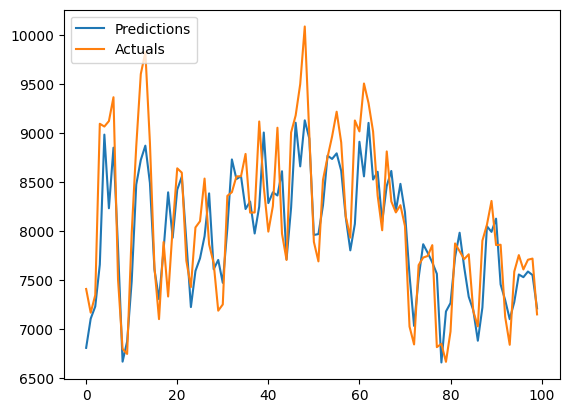

MAPE: 3.34%
RMSE: 370.74
MAE : 271.97


Predictions      Actuals
0    6812.118652  7412.811667
1    7109.795898  7171.183125
2    7234.315430  7350.264167
3    7661.751953  9098.258333
4    8987.569336  9070.002917
..           ...          ...
719  7750.565918  7374.332292
720  8213.395508  8039.583333
721  8298.179688  8575.767292
722  8104.179199  7909.507917
723  7419.445312  7144.386250

[724 rows x 2 columns]

In [193]:
predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


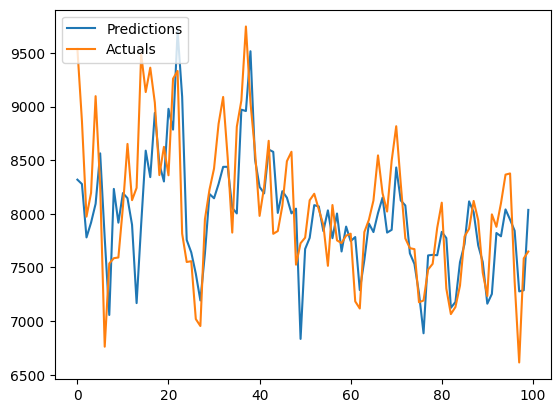

MAPE: 3.43%
RMSE: 362.11
MAE : 274.19


Predictions      Actuals
0    8318.349609  9537.097917
1    8277.330078  8863.333125
2    7779.986328  7973.787500
3    7918.096191  8194.981667
4    8093.423828  9096.434375
..           ...          ...
353  8160.204590  8447.030417
354  8598.582031  8771.408958
355  8614.841797  8487.014792
356  8212.573242  8380.489792
357  8006.739746  8437.980833

[358 rows x 2 columns]

In [194]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


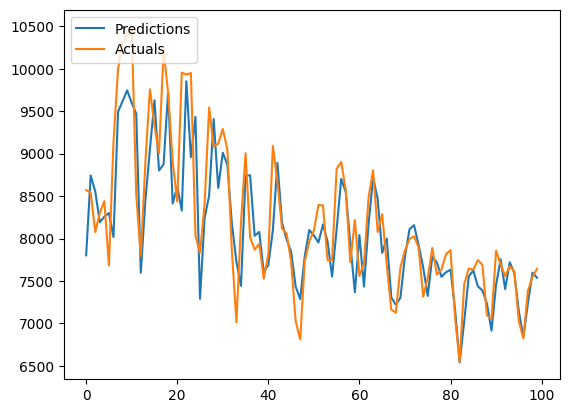

MAPE: 3.78%
RMSE: 400.74
MAE : 301.78


Predictions      Actuals
0    7802.413086  8569.568125
1    8742.965820  8540.904167
2    8554.017578  8076.513125
3    8191.996094  8302.971875
4    8258.672852  8440.820000
..           ...          ...
353  8060.150879  7508.199792
354  8245.223633  7694.271458
355  8277.184570  7746.240833
356  8115.007812  8321.401042
357  8094.358887  8503.726875

[358 rows x 2 columns]

In [195]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

## Seasonality ##

## Seasons ##

In [211]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
seasonsDemandDF['temp_range'] = seasonsDemandDF['max_temp'] - seasonsDemandDF['min_temp']
seasonsDemandDF.head()

is_winter  is_spring  is_summer  is_autumn  avg_30_min_demand  \
datetime_au                                                                  
2016-01-01           0          0          1          0        6861.518333   
2016-01-02           0          0          1          0        6731.957292   
2016-01-03           0          0          1          0        6618.040000   
2016-01-04           0          0          1          0        7358.550000   
2016-01-05           0          0          1          0        7460.061875   

              avg_temp  min_temp  max_temp  hd_next_24h  cd_next_24h  \
datetime_au                                                            
2016-01-01   20.704082      15.2      26.0          0.0     1.204082   
2016-01-02   20.572917      14.9      24.2          0.0     1.072917   
2016-01-03   21.130769      19.0      22.9          0.0     1.630769   
2016-01-04   20.144444      18.4      23.1          0.0     0.644444   
2016-01-05   18.904808      17.4      20.3          0.0     0.000000   

             temp_range  
datetime_au              
2016-01-01         10.8  
2016-01-02          9.3  
2016-01-03          3.9  
2016-01-04          4.7  
2016-01-05          2.9

In [212]:
preprocessor15 = TimeSeriesPreprocessor(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor15.split()
preprocessor15.scale()
data15 = preprocessor15.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

In [213]:
X_train15.shape, y_train15.shape, X_val15.shape, y_val15.shape, X_test15.shape, y_test15.shape

((724, 7, 11), (724,), (358, 7, 11), (358,), (358, 7, 11), (358,))

In [214]:
model15 = Sequential()
model15.add(InputLayer((7, 11)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [215]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [216]:
model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0984 - root_mean_squared_error: 0.3048 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0238 - root_mean_squared_error: 0.1536 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - root_mean_squared_error: 0.1258 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

In [217]:
model15 = load_model('model15.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


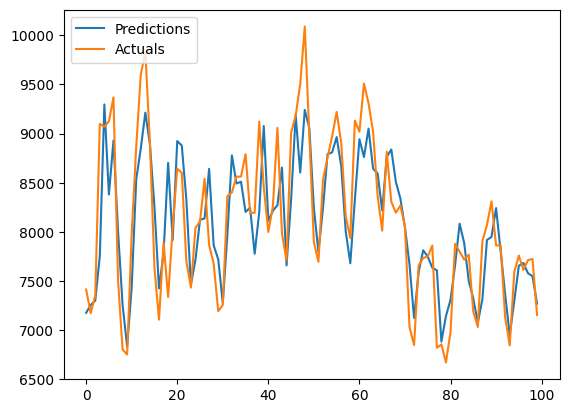

MAPE: 3.27%
RMSE: 366.28
MAE : 264.94


Predictions      Actuals
0    7174.908691  7412.811667
1    7255.254883  7171.183125
2    7298.872559  7350.264167
3    7752.249512  9098.258333
4    9296.909180  9070.002917
..           ...          ...
719  7767.381348  7374.332292
720  8259.189453  8039.583333
721  8421.545898  8575.767292
722  8239.334961  7909.507917
723  7476.702148  7144.386250

[724 rows x 2 columns]

In [218]:
predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


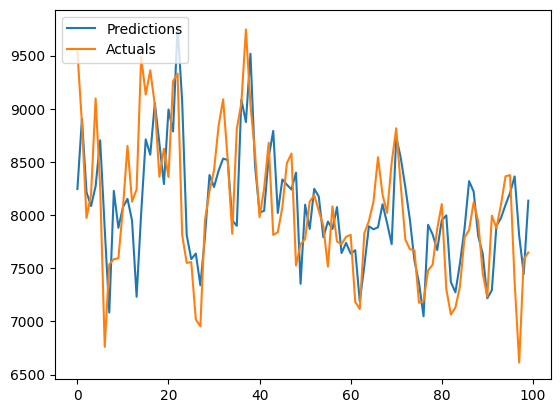

MAPE: 3.49%
RMSE: 371.00
MAE : 278.27


Predictions      Actuals
0    8245.193359  9537.097917
1    8903.846680  8863.333125
2    8215.868164  7973.787500
3    8085.439453  8194.981667
4    8271.449219  9096.434375
..           ...          ...
353  8119.978516  8447.030417
354  8598.871094  8771.408958
355  8407.702148  8487.014792
356  7856.853516  8380.489792
357  7580.738770  8437.980833

[358 rows x 2 columns]

In [220]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


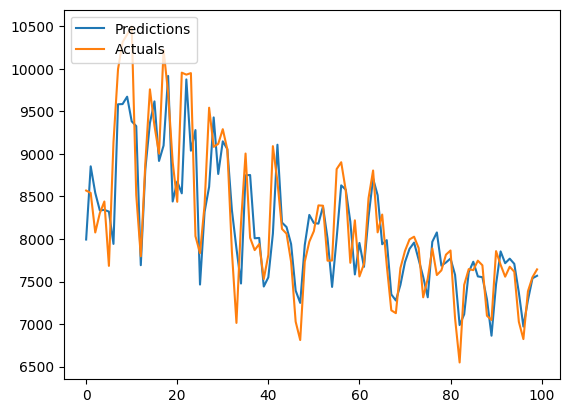

MAPE: 3.69%
RMSE: 385.61
MAE : 292.56


Predictions      Actuals
0    7993.961426  8569.568125
1    8854.038086  8540.904167
2    8541.882812  8076.513125
3    8336.649414  8302.971875
4    8342.031250  8440.820000
..           ...          ...
353  7973.971191  7508.199792
354  8109.879883  7694.271458
355  8163.277832  7746.240833
356  8053.686523  8321.401042
357  7870.414062  8503.726875

[358 rows x 2 columns]

In [221]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [288]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
weekendDemandDF['temp_range'] = weekendDemandDF['max_temp'] - weekendDemandDF['min_temp']
weekendDemandDF.head()

is_weekday  is_weekend  avg_30_min_demand   avg_temp  min_temp  \
datetime_au                                                                   
2016-01-01            1           0        6861.518333  20.704082      15.2   
2016-01-02            0           1        6731.957292  20.572917      14.9   
2016-01-03            0           1        6618.040000  21.130769      19.0   
2016-01-04            1           0        7358.550000  20.144444      18.4   
2016-01-05            1           0        7460.061875  18.904808      17.4   

             max_temp  hd_next_24h  cd_next_24h  temp_range  
datetime_au                                                  
2016-01-01       26.0          0.0     1.204082        10.8  
2016-01-02       24.2          0.0     1.072917         9.3  
2016-01-03       22.9          0.0     1.630769         3.9  
2016-01-04       23.1          0.0     0.644444         4.7  
2016-01-05       20.3          0.0     0.000000         2.9

In [225]:
preprocessor16 = TimeSeriesPreprocessor(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor16.split()
preprocessor16.scale()
data16 = preprocessor16.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

In [226]:
X_train16.shape, y_train16.shape, X_val16.shape, y_val16.shape, X_test16.shape, y_test16.shape

((724, 7, 9), (724,), (358, 7, 9), (358,), (358, 7, 9), (358,))

In [227]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [228]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [229]:
model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0299 - root_mean_squared_error: 0.1721 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - root_mean_squared_error: 0.1197 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step -

In [230]:
model16 = load_model('model16.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


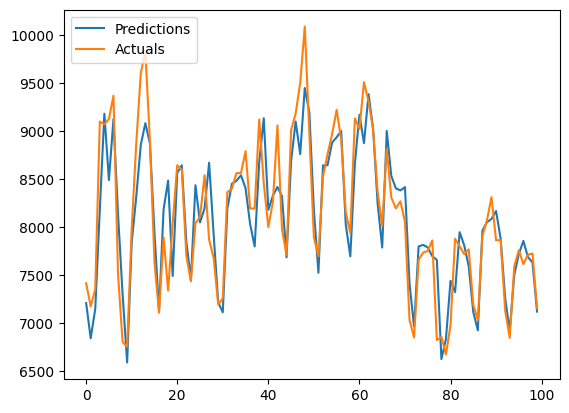

MAPE: 2.57%
RMSE: 297.53
MAE : 207.18


Predictions      Actuals
0    7205.838379  7412.811667
1    6839.165527  7171.183125
2    7144.355469  7350.264167
3    8180.288574  9098.258333
4    9180.841797  9070.002917
..           ...          ...
719  7310.511719  7374.332292
720  7825.972656  8039.583333
721  8171.874023  8575.767292
722  7773.843262  7909.507917
723  7211.428223  7144.386250

[724 rows x 2 columns]

In [231]:
predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


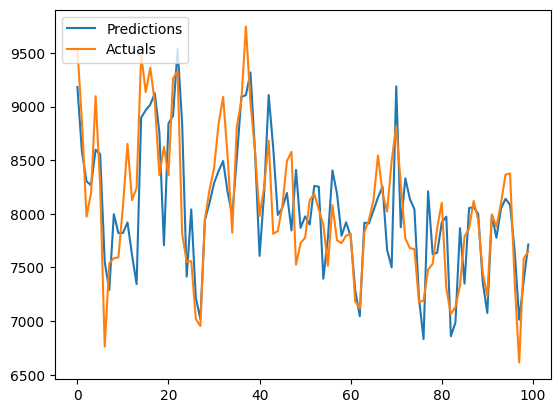

MAPE: 2.86%
RMSE: 311.34
MAE : 227.60


Predictions      Actuals
0    9181.305664  9537.097917
1    8577.385742  8863.333125
2    8303.096680  7973.787500
3    8265.265625  8194.981667
4    8597.263672  9096.434375
..           ...          ...
353  7578.950195  8447.030417
354  8142.768555  8771.408958
355  7850.050293  8487.014792
356  7676.728027  8380.489792
357  8335.708984  8437.980833

[358 rows x 2 columns]

In [232]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


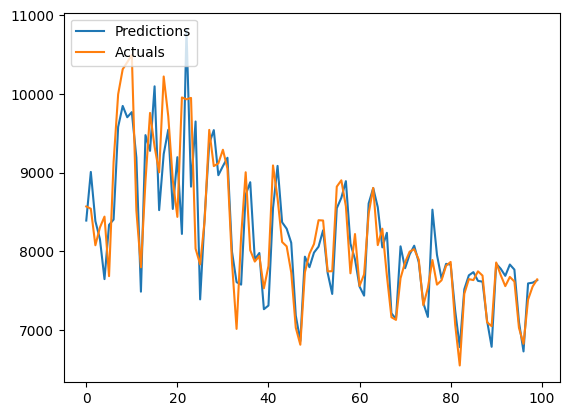

MAPE: 3.10%
RMSE: 349.69
MAE : 248.15


Predictions      Actuals
0    8390.679688  8569.568125
1    9008.585938  8540.904167
2    8383.876953  8076.513125
3    8154.803711  8302.971875
4    7646.506836  8440.820000
..           ...          ...
353  7323.463867  7508.199792
354  7115.617188  7694.271458
355  7667.693848  7746.240833
356  8372.461914  8321.401042
357  8191.095215  8503.726875

[358 rows x 2 columns]

In [233]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [234]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
dayDemandDF['temp_range'] = dayDemandDF['max_temp'] - dayDemandDF['min_temp']
dayDemandDF.head()

is_sunday  is_monday  is_tuesday  is_wednesday  is_thursday  \
datetime_au                                                                
2016-01-01           0          0           0             0            0   
2016-01-02           0          0           0             0            0   
2016-01-03           1          0           0             0            0   
2016-01-04           0          1           0             0            0   
2016-01-05           0          0           1             0            0   

             is_friday  is_saturday  avg_30_min_demand   avg_temp  min_temp  \
datetime_au                                                                   
2016-01-01           1            0        6861.518333  20.704082      15.2   
2016-01-02           0            1        6731.957292  20.572917      14.9   
2016-01-03           0            0        6618.040000  21.130769      19.0   
2016-01-04           0            0        7358.550000  20.144444      18.4   
2016-01-05           0            0        7460.061875  18.904808      17.4   

             max_temp  hd_next_24h  cd_next_24h  temp_range  
datetime_au                                                  
2016-01-01       26.0          0.0     1.204082        10.8  
2016-01-02       24.2          0.0     1.072917         9.3  
2016-01-03       22.9          0.0     1.630769         3.9  
2016-01-04       23.1          0.0     0.644444         4.7  
2016-01-05       20.3          0.0     0.000000         2.9

In [235]:
preprocessor17 = TimeSeriesPreprocessor(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor17.split()
preprocessor17.scale()
data17 = preprocessor17.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

In [236]:
X_train17.shape, y_train17.shape, X_val17.shape, y_val17.shape, X_test17.shape, y_test17.shape

((724, 7, 14), (724,), (358, 7, 14), (358,), (358, 7, 14), (358,))

In [237]:
model17 = Sequential()
model17.add(InputLayer((7, 14)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [238]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [239]:
model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0849 - root_mean_squared_error: 0.2835 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0210 - root_mean_squared_error: 0.1444 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - root_mean_squared_error: 0.1145 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

In [240]:
model17 = load_model('model17.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


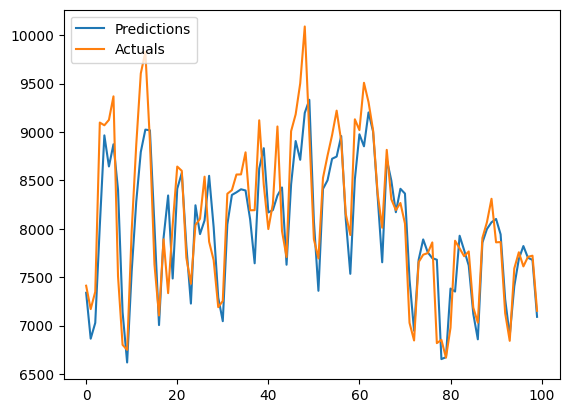

MAPE: 2.68%
RMSE: 315.73
MAE : 217.90


Predictions      Actuals
0    7339.752441  7412.811667
1    6865.491699  7171.183125
2    7028.883789  7350.264167
3    8031.941406  9098.258333
4    8965.876953  9070.002917
..           ...          ...
719  7123.148438  7374.332292
720  7840.102051  8039.583333
721  7940.098145  8575.767292
722  7865.183594  7909.507917
723  7228.737305  7144.386250

[724 rows x 2 columns]

In [241]:
predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


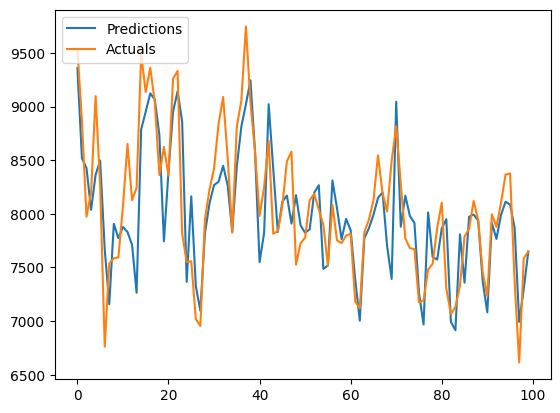

MAPE: 2.87%
RMSE: 311.59
MAE : 228.72


Predictions      Actuals
0    9357.365234  9537.097917
1    8518.087891  8863.333125
2    8425.889648  7973.787500
3    8036.753906  8194.981667
4    8364.065430  9096.434375
..           ...          ...
353  7577.810547  8447.030417
354  7996.210938  8771.408958
355  7938.865723  8487.014792
356  7590.635742  8380.489792
357  8636.036133  8437.980833

[358 rows x 2 columns]

In [242]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


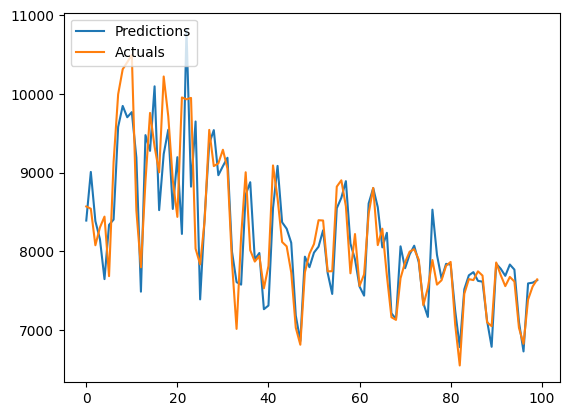

MAPE: 3.10%
RMSE: 349.69
MAE : 248.15


Predictions      Actuals
0    8390.679688  8569.568125
1    9008.585938  8540.904167
2    8383.876953  8076.513125
3    8154.803711  8302.971875
4    7646.506836  8440.820000
..           ...          ...
353  7323.463867  7508.199792
354  7115.617188  7694.271458
355  7667.693848  7746.240833
356  8372.461914  8321.401042
357  8191.095215  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

In [244]:
test_df2 = test_df[['is_weekend','is_weekday','is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
test_df2['temp_range'] = test_df2['max_temp'] - test_df2['min_temp']
test_df2.head()

is_weekend  is_weekday  is_sunday  is_monday  is_tuesday  \
datetime_au                                                             
2016-01-01            0           1          0          0           0   
2016-01-02            1           0          0          0           0   
2016-01-03            1           0          1          0           0   
2016-01-04            0           1          0          1           0   
2016-01-05            0           1          0          0           1   

             is_wednesday  is_thursday  is_friday  is_saturday  \
datetime_au                                                      
2016-01-01              0            0          1            0   
2016-01-02              0            0          0            1   
2016-01-03              0            0          0            0   
2016-01-04              0            0          0            0   
2016-01-05              0            0          0            0   

             avg_30_min_demand   avg_temp  min_temp  max_temp  hd_next_24h  \
datetime_au                                                                  
2016-01-01         6861.518333  20.704082      15.2      26.0          0.0   
2016-01-02         6731.957292  20.572917      14.9      24.2          0.0   
2016-01-03         6618.040000  21.130769      19.0      22.9          0.0   
2016-01-04         7358.550000  20.144444      18.4      23.1          0.0   
2016-01-05         7460.061875  18.904808      17.4      20.3          0.0   

             cd_next_24h  temp_range  
datetime_au                           
2016-01-01      1.204082        10.8  
2016-01-02      1.072917         9.3  
2016-01-03      1.630769         3.9  
2016-01-04      0.644444         4.7  
2016-01-05      0.000000         2.9

In [245]:
## Test correlation ##

# Define the day-of-week one-hot column names
day_of_week_columns = [
    'is_monday', 'is_tuesday', 'is_wednesday',
    'is_thursday', 'is_friday', 'is_saturday', 'is_sunday'
]

# Combine with binary flags
cols_to_check = ['is_weekend', 'is_weekday'] + day_of_week_columns

# Compute correlation matrix
corr_matrix = test_df2[cols_to_check].corr()

# Display
print(corr_matrix)

              is_weekend  is_weekday  is_monday  is_tuesday  is_wednesday  \
is_weekend      1.000000   -1.000000  -0.258653   -0.258653     -0.257930   
is_weekday     -1.000000    1.000000   0.258653    0.258653      0.257930   
is_monday      -0.258653    0.258653   1.000000   -0.166933     -0.166467   
is_tuesday     -0.258653    0.258653  -0.166933    1.000000     -0.166467   
is_wednesday   -0.257930    0.257930  -0.166467   -0.166467      1.000000   
is_thursday    -0.257930    0.257930  -0.166467   -0.166467     -0.166002   
is_friday      -0.258653    0.258653  -0.166933   -0.166933     -0.166467   
is_saturday     0.645394   -0.645394  -0.166933   -0.166933     -0.166467   
is_sunday       0.645394   -0.645394  -0.166933   -0.166933     -0.166467   

              is_thursday  is_friday  is_saturday  is_sunday  
is_weekend      -0.257930  -0.258653     0.645394   0.645394  
is_weekday       0.257930   0.258653    -0.645394  -0.645394  
is_monday       -0.166467  -0.166933    

## Month ##

In [246]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
monthDemandDF['temp_range'] = monthDemandDF['max_temp'] - monthDemandDF['min_temp']
monthDemandDF.head()

is_jan  is_feb  is_mar  is_apr  is_may  is_jun  is_jul  is_aug  \
datetime_au                                                                   
2016-01-01        1       0       0       0       0       0       0       0   
2016-01-02        1       0       0       0       0       0       0       0   
2016-01-03        1       0       0       0       0       0       0       0   
2016-01-04        1       0       0       0       0       0       0       0   
2016-01-05        1       0       0       0       0       0       0       0   

             is_sep  is_oct  is_nov  is_dec  avg_30_min_demand   avg_temp  \
datetime_au                                                                 
2016-01-01        0       0       0       0        6861.518333  20.704082   
2016-01-02        0       0       0       0        6731.957292  20.572917   
2016-01-03        0       0       0       0        6618.040000  21.130769   
2016-01-04        0       0       0       0        7358.550000  20.144444   
2016-01-05        0       0       0       0        7460.061875  18.904808   

             min_temp  max_temp  hd_next_24h  cd_next_24h  temp_range  
datetime_au                                                            
2016-01-01       15.2      26.0          0.0     1.204082        10.8  
2016-01-02       14.9      24.2          0.0     1.072917         9.3  
2016-01-03       19.0      22.9          0.0     1.630769         3.9  
2016-01-04       18.4      23.1          0.0     0.644444         4.7  
2016-01-05       17.4      20.3          0.0     0.000000         2.9

In [247]:
preprocessor18 = TimeSeriesPreprocessor(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor18.split()
preprocessor18.scale()
data18 = preprocessor18.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

In [248]:
X_train18.shape, y_train18.shape, X_val18.shape, y_val18.shape, X_test18.shape, y_test18.shape

((724, 7, 19), (724,), (358, 7, 19), (358,), (358, 7, 19), (358,))

In [249]:
model18 = Sequential()
model18.add(InputLayer((7, 19)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [251]:
model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1322 - root_mean_squared_error: 0.3505 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - root_mean_squared_error: 0.1406 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [252]:
model18 = load_model('model18.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


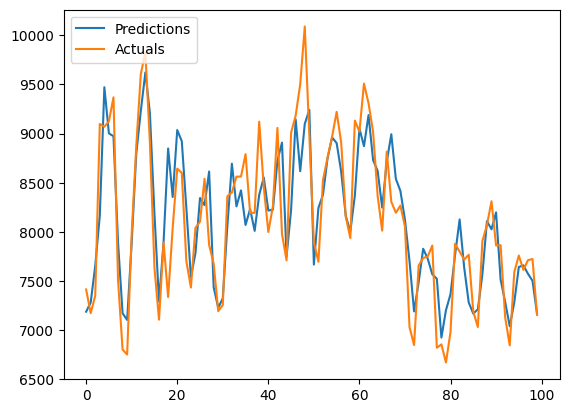

MAPE: 3.02%
RMSE: 337.54
MAE : 243.41


Predictions      Actuals
0    7186.550781  7412.811667
1    7280.725586  7171.183125
2    7654.839355  7350.264167
3    8166.979492  9098.258333
4    9472.424805  9070.002917
..           ...          ...
719  7797.529785  7374.332292
720  8069.773926  8039.583333
721  8138.359375  8575.767292
722  8224.419922  7909.507917
723  7439.615234  7144.386250

[724 rows x 2 columns]

In [253]:
predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


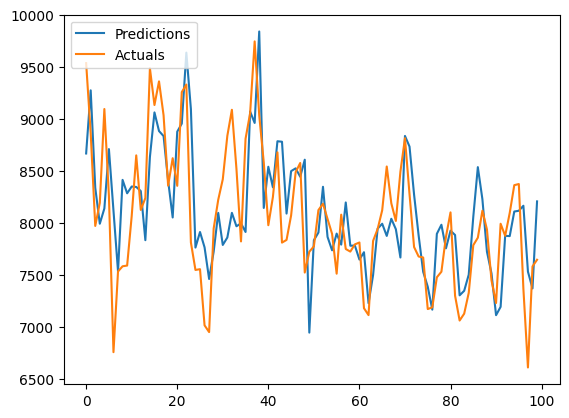

MAPE: 3.63%
RMSE: 382.72
MAE : 288.93


Predictions      Actuals
0    8669.413086  9537.097917
1    9275.740234  8863.333125
2    8340.289062  7973.787500
3    7994.908203  8194.981667
4    8141.455566  9096.434375
..           ...          ...
353  7852.977051  8447.030417
354  8308.778320  8771.408958
355  8377.430664  8487.014792
356  7879.952637  8380.489792
357  7655.711426  8437.980833

[358 rows x 2 columns]

In [254]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


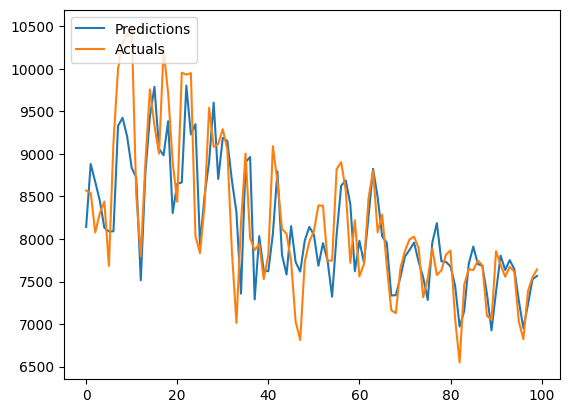

MAPE: 3.90%
RMSE: 412.29
MAE : 308.85


Predictions      Actuals
0    8141.980957  8569.568125
1    8880.802734  8540.904167
2    8670.500977  8076.513125
3    8450.304688  8302.971875
4    8131.686035  8440.820000
..           ...          ...
353  7717.141113  7508.199792
354  7934.963379  7694.271458
355  7849.019531  7746.240833
356  7813.736328  8321.401042
357  7841.120605  8503.726875

[358 rows x 2 columns]

In [255]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [256]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h']].copy()
seasonsWdWeDemandDF['temp_range'] = seasonsWdWeDemandDF['max_temp'] - seasonsWdWeDemandDF['min_temp']
seasonsWdWeDemandDF.head()

is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  avg_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0        6861.518333  20.704082      15.2      26.0   
2016-01-02           0        6731.957292  20.572917      14.9      24.2   
2016-01-03           0        6618.040000  21.130769      19.0      22.9   
2016-01-04           0        7358.550000  20.144444      18.4      23.1   
2016-01-05           0        7460.061875  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range  
datetime_au                                        
2016-01-01           0.0     1.204082        10.8  
2016-01-02           0.0     1.072917         9.3  
2016-01-03           0.0     1.630769         3.9  
2016-01-04           0.0     0.644444         4.7  
2016-01-05           0.0     0.000000         2.9

In [257]:
preprocessor19 = TimeSeriesPreprocessor(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor19.split()
preprocessor19.scale()
data19 = preprocessor19.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

In [258]:
X_train19.shape, y_train19.shape, X_val19.shape, y_val19.shape, X_test19.shape, y_test19.shape

((724, 7, 13), (724,), (358, 7, 13), (358,), (358, 7, 13), (358,))

In [259]:
model19 = Sequential()
model19.add(InputLayer((7, 13)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [260]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [261]:
model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1256 - root_mean_squared_error: 0.3441 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1301 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

In [262]:
model19 = load_model('model19.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


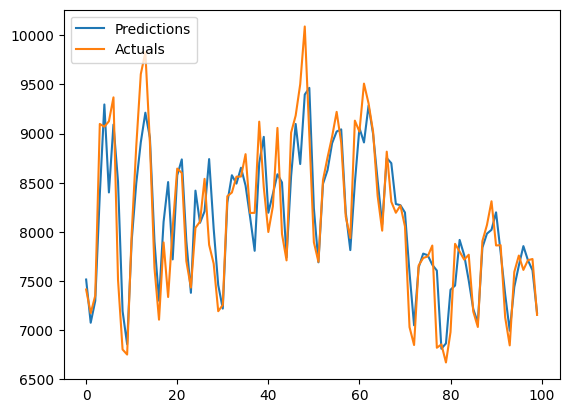

MAPE: 2.70%
RMSE: 313.54
MAE : 217.39


Predictions      Actuals
0    7514.083496  7412.811667
1    7074.186035  7171.183125
2    7297.091309  7350.264167
3    8381.008789  9098.258333
4    9296.742188  9070.002917
..           ...          ...
719  7581.221680  7374.332292
720  8058.069336  8039.583333
721  8230.233398  8575.767292
722  7927.099121  7909.507917
723  7279.191895  7144.386250

[724 rows x 2 columns]

In [263]:
predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


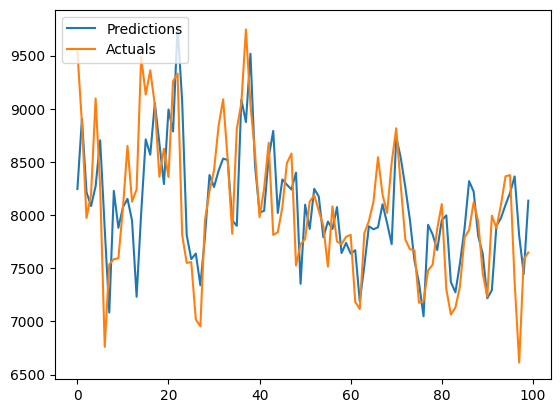

MAPE: 3.49%
RMSE: 371.00
MAE : 278.27


Predictions      Actuals
0    8245.193359  9537.097917
1    8903.846680  8863.333125
2    8215.868164  7973.787500
3    8085.439453  8194.981667
4    8271.449219  9096.434375
..           ...          ...
353  8119.978516  8447.030417
354  8598.871094  8771.408958
355  8407.702148  8487.014792
356  7856.853516  8380.489792
357  7580.738770  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


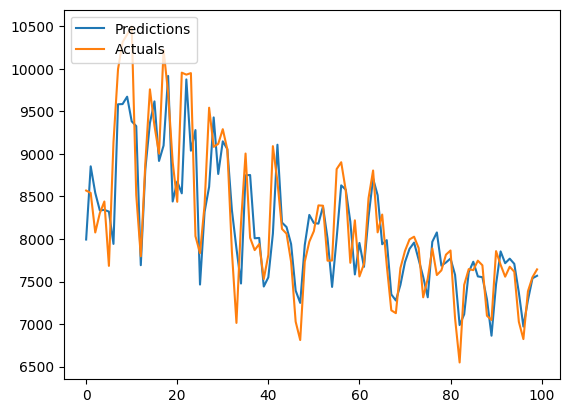

MAPE: 3.69%
RMSE: 385.61
MAE : 292.56


Predictions      Actuals
0    7993.961426  8569.568125
1    8854.038086  8540.904167
2    8541.882812  8076.513125
3    8336.649414  8302.971875
4    8342.031250  8440.820000
..           ...          ...
353  7973.971191  7508.199792
354  8109.879883  7694.271458
355  8163.277832  7746.240833
356  8053.686523  8321.401042
357  7870.414062  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [267]:
preprocessor20 = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor20.split()
preprocessor20.scale()
data20 = preprocessor20.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

In [269]:
X_train20.shape, y_train20.shape, X_test20.shape, y_test20.shape

((1089, 7, 13), (1089,), (358, 7, 13), (358,))

In [270]:
model20 = Sequential()
model20.add(InputLayer((7, 13)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [271]:
cp20 = ModelCheckpoint('model20.keras', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [272]:
model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1037 - root_mean_squared_error: 0.3085
Epoch 2/100
24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - root_mean_squared_error: 0.1279

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - root_mean_squared_error: 0.1257
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943
Epoch 12/1

In [273]:
model20 = load_model('model20.keras')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


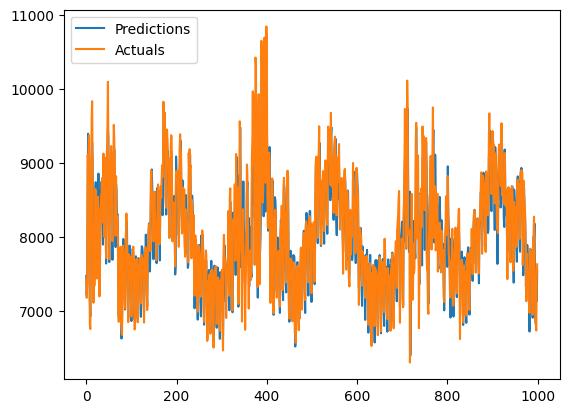

MAPE: 2.65%
RMSE: 308.53
MAE : 213.61


Predictions      Actuals
0     7469.185059  7412.811667
1     7209.871582  7171.183125
2     7351.578613  7350.264167
3     8350.498047  9098.258333
4     9388.514648  9070.002917
...           ...          ...
1084  7918.362793  8447.030417
1085  8430.145508  8771.408958
1086  8201.347656  8487.014792
1087  7944.089355  8380.489792
1088  8792.750977  8437.980833

[1089 rows x 2 columns]

In [275]:
predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


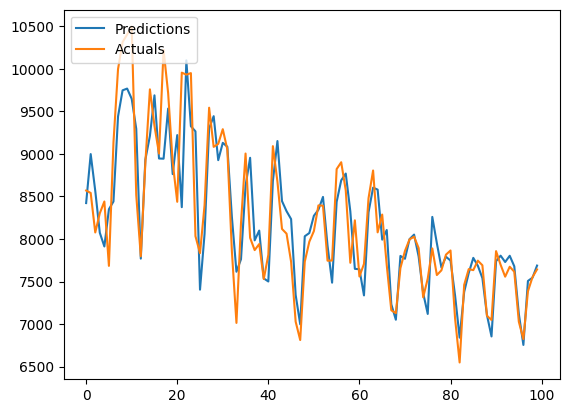

MAPE: 2.95%
RMSE: 335.27
MAE : 235.76


Predictions      Actuals
0    8422.249023  8569.568125
1    8997.993164  8540.904167
2    8566.276367  8076.513125
3    8073.459473  8302.971875
4    7912.203125  8440.820000
..           ...          ...
353  7511.994141  7508.199792
354  7355.356445  7694.271458
355  7773.261719  7746.240833
356  8510.354492  8321.401042
357  8337.705078  8503.726875

[358 rows x 2 columns]

In [276]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [280]:
preprocessor21 = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor21.split()
preprocessor21.scale()
data21 = preprocessor21.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

In [281]:
X_train21.shape, y_train21.shape, X_test21.shape, y_test21.shape

((1089, 7, 11), (1089,), (358, 7, 11), (358,))

In [282]:
model21 = Sequential()
model21.add(InputLayer((7, 11)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
cp21 = ModelCheckpoint('model21.keras', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [284]:
model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0467 - root_mean_squared_error: 0.2103
Epoch 2/100
12/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - root_mean_squared_error: 0.1327  

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1209
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1127
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121
Epoch 12/1

In [285]:
model21 = load_model('model21.keras')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


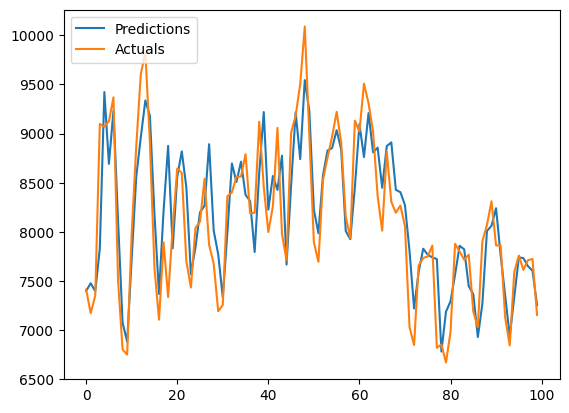

MAPE: 3.17%
RMSE: 347.47
MAE : 253.97


Predictions      Actuals
0     7397.788086  7412.811667
1     7476.188965  7171.183125
2     7394.870605  7350.264167
3     7829.556641  9098.258333
4     9422.844727  9070.002917
...           ...          ...
1084  8040.379395  8447.030417
1085  8714.902344  8771.408958
1086  8746.302734  8487.014792
1087  8181.962891  8380.489792
1088  8071.894531  8437.980833

[1089 rows x 2 columns]

In [286]:
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


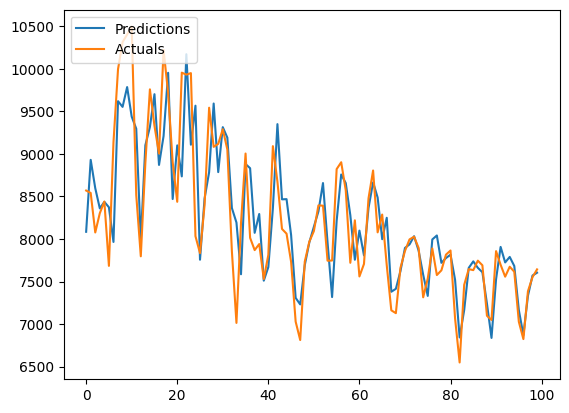

MAPE: 3.58%
RMSE: 385.86
MAE : 283.22


Predictions      Actuals
0    8084.835938  8569.568125
1    8930.277344  8540.904167
2    8597.341797  8076.513125
3    8359.947266  8302.971875
4    8436.601562  8440.820000
..           ...          ...
353  7941.818848  7508.199792
354  8072.901367  7694.271458
355  8200.901367  7746.240833
356  8091.145996  8321.401042
357  8391.972656  8503.726875

[358 rows x 2 columns]

In [287]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [289]:
preprocessor22 = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor22.split()
preprocessor22.scale()
data22 = preprocessor22.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

In [290]:
X_train22.shape, y_train22.shape, X_test22.shape, y_test22.shape

((1089, 7, 9), (1089,), (358, 7, 9), (358,))

In [291]:
model22 = Sequential()
model22.add(InputLayer((7, 9)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [292]:
cp22 = ModelCheckpoint('model22.keras', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

In [293]:
model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1307 - root_mean_squared_error: 0.3469
Epoch 2/100
25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - root_mean_squared_error: 0.1297

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - root_mean_squared_error: 0.1078
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011
Epoch 12/1

In [294]:
model22 = load_model('model22.keras')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


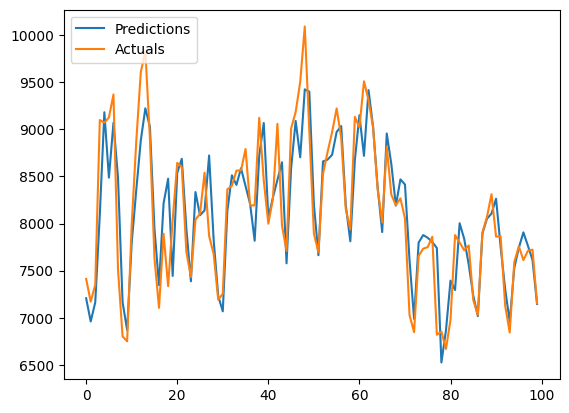

MAPE: 2.72%
RMSE: 310.39
MAE : 218.63


Predictions      Actuals
0     7207.132812  7412.811667
1     6960.746094  7171.183125
2     7163.608398  7350.264167
3     8094.450195  9098.258333
4     9180.898438  9070.002917
...           ...          ...
1084  7681.644531  8447.030417
1085  8287.161133  8771.408958
1086  8092.338867  8487.014792
1087  7881.349121  8380.489792
1088  8615.953125  8437.980833

[1089 rows x 2 columns]

In [295]:
predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


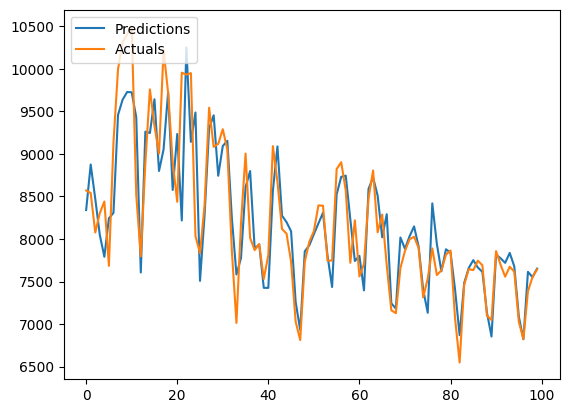

MAPE: 3.08%
RMSE: 343.34
MAE : 246.25


Predictions      Actuals
0    8339.998047  8569.568125
1    8875.371094  8540.904167
2    8472.845703  8076.513125
3    8048.059082  8302.971875
4    7791.187500  8440.820000
..           ...          ...
353  7284.364258  7508.199792
354  7230.993164  7694.271458
355  7624.374512  7746.240833
356  8327.464844  8321.401042
357  8195.318359  8503.726875

[358 rows x 2 columns]

In [298]:
predictions_plot(model22, X_test22, y_test22, 0, 100)